# Import

## Libraries 

In [1]:
#Intake is a package to load and share datasets, and will be our connection to the cloud via the
#intake-esm catalogue.
import intake

#Xarray is essentially Pandas for n-dimensional datasets (which will be the outputs from
#climate models)
import xarray as xr

#Proplot is the 'next big thing' for data visualisation in Python, apparently.
import proplot

#NetCDF for importing observed datasets
import netCDF4

#These modules are imported for obvious reasons
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})
plt.style.use('default')

#Parallelisation
from joblib import Parallel, delayed

#remove any warning messages
import warnings
warnings.filterwarnings('ignore')

## GISS Model Experiments

### Data Catalogue

We read the data catalogue provided by https://pangeo.io/cloud.html:

In [2]:
#necessary url
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

#open the catalog
dataframe = intake.open_esm_datastore(url)

Check that this dataframe has actually worked:

In [3]:
dataframe

We can see this tells us the number of different model catagories we are able to choose from. <br>We now choose the model from this list, with the <u>following specification</u>:
- source_id = <b>IPSL-CM6A-LR</b> (the name of the model)
- experiment_id = <bhistorical</b> and <b>AMIP</b> (the ensemble experiments)
- table_id = <b>Amon</b> (monthly atmospheric variables)
- variable_id = <b>tas</b> (temperature at the surface), <b>pr</b> (precipitation flux) and <b>psl</b> (pressure at sea level).

In [4]:
#Historical and AMIP model ensembles
model_ensembles = dataframe.search(source_id='IPSL-CM6A-LR',
                                         experiment_id=['historical', 'amip'],
                                         table_id='Amon',
                                         variable_id=['tas','pr','psl'])

This query yields an intake_esm.core.esm_datastore data type, which we can use in order to get the dataset we have searched for.
<br>Before we do this, let's learn a bit more about the model ensembles we're importing:

In [5]:
model_ensembles

### A Look into Ensemble Metadata

In [ ]:
print(model_ensembles.df.head().to_latex(index=False))

In [4]:
model_ensembles.df.loc[model_ensembles.df['experiment_id'] == 'historical'].head()

activity_id institution_id     source_id experiment_id member_id table_id  \
0        CMIP           IPSL  IPSL-CM6A-LR    historical  r8i1p1f1     Amon   
1        CMIP           IPSL  IPSL-CM6A-LR    historical  r8i1p1f1     Amon   
2        CMIP           IPSL  IPSL-CM6A-LR    historical  r8i1p1f1     Amon   
3        CMIP           IPSL  IPSL-CM6A-LR    historical  r2i1p1f1     Amon   
4        CMIP           IPSL  IPSL-CM6A-LR    historical  r2i1p1f1     Amon   

  variable_id grid_label                                             zstore  \
0          pr         gr  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
1         psl         gr  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
2         tas         gr  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
3          pr         gr  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
4         psl         gr  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   

   dcpp_init_year   version  
0             NaN  20180803  
1             NaN  20180803  
2             NaN  20180803  
3             NaN  20180803  
4             NaN  20180803

In [5]:
print(
    'The number of simulations in the historical ensemble for temperature at surface (tas) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'historical')
        & (model_ensembles.df['variable_id'] == 'tas')].shape[0])

The number of simulations in the historical ensemble for temperature at surface (tas) is: 32


In [6]:
print(
    'The number of simulations in the historical ensemble for precipitation flux (pr)) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'historical')
        & (model_ensembles.df['variable_id'] == 'pr')].shape[0])

The number of simulations in the historical ensemble for precipitation flux (pr)) is: 32


In [7]:
print(
    'The number of simulations in the historical ensemble for air pressure at sea level (psl) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'historical')
        & (model_ensembles.df['variable_id'] == 'psl')].shape[0])

The number of simulations in the historical ensemble for air pressure at sea level (psl) is: 32


<u>Notice:</u> The number of historical simulations for each variable is the same, which is good news!

In [138]:
model_ensembles.df.loc[model_ensembles.df['experiment_id'] == 'amip'].head()

activity_id institution_id    source_id experiment_id member_id table_id  \
10        CMIP      NASA-GISS  GISS-E2-1-G          amip  r5i1p1f1     Amon   
11        CMIP      NASA-GISS  GISS-E2-1-G          amip  r4i1p1f1     Amon   
12        CMIP      NASA-GISS  GISS-E2-1-G          amip  r3i1p1f1     Amon   
13        CMIP      NASA-GISS  GISS-E2-1-G          amip  r1i1p1f1     Amon   
14        CMIP      NASA-GISS  GISS-E2-1-G          amip  r2i1p1f1     Amon   

   variable_id grid_label                                             zstore  \
10         tas         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/am...   
11         tas         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/am...   
12         tas         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/am...   
13         tas         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/am...   
14         tas         gn  gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/am...   

    dcpp_init_year   version  
10             NaN  20181016  
11             NaN  20181016  
12             NaN  20181016  
13             NaN  20181016  
14             NaN  20181016

In [8]:
print(
    'The number of simulations in the AMIP ensemble for temperature at surface (tas) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'amip')
        & (model_ensembles.df['variable_id'] == 'tas')].shape[0])

The number of simulations in the AMIP ensemble for temperature at surface (tas) is: 21


In [9]:
print(
    'The number of simulations in the AMIP ensemble for precipitation flux (pr) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'amip')
        & (model_ensembles.df['variable_id'] == 'pr')].shape[0])

The number of simulations in the AMIP ensemble for precipitation flux (pr) is: 21


In [10]:
print(
    'The number of simulations in the AMIP ensemble for air pressure at sea level (psl) is:',
    model_ensembles.df.loc[
        (model_ensembles.df['experiment_id'] == 'amip')
        & (model_ensembles.df['variable_id'] == 'psl')].shape[0])

The number of simulations in the AMIP ensemble for air pressure at sea level (psl) is: 21


<u>Notice:</u> The number of AMIP simulations for each variable is the same, which is good news!

### Downloading the Data

In [6]:
model_ensembles_dataset = model_ensembles.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


We check what we have downloaded:

In [7]:
model_ensembles_dataset.keys()

dict_keys(['CMIP.IPSL.IPSL-CM6A-LR.amip.Amon.gr', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr'])

In [8]:
#AMIP datasets
model_amip_ds = model_ensembles_dataset['CMIP.IPSL.IPSL-CM6A-LR.amip.Amon.gr']

#Historical datasets
model_historical_ds = model_ensembles_dataset['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']

# Analysing the Model

## Checking the Data Structure

The above are xarray.core.dataset.Dataset straight away, meaning they can be readily used for anything one would want with the Xarray package (which is suited to work with gridded meteorological data).

In [14]:
model_amip_ds

<xarray.Dataset>
Dimensions:      (member_id: 21, time: 720, lat: 143, lon: 144, axis_nbounds: 2)
Coordinates:
  * member_id    (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
  * time         (time) datetime64[ns] 1958-01-16T12:00:00 ... 2017-12-16T12:...
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(720, 2), meta=np.ndarray>
    height       float64 ...
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 342, 143, 144), meta=np.ndarray>
    psl          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 342, 143, 144), meta=np.ndarray>
    tas          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 342, 143, 144), meta=np.ndarray>
Attributes: (12/55)
    status:                  2020-05-01;created; by gcs.cmip6.ldeo@gmail.com
    creation_date:           2019-05-14T13:35:06Z
    description:             DECK: AMIP
    grid:                    LMDZ grid
    sub_experiment_id:       none
    netcdf_tracking_ids:     hdl:21.14100/b446da0c-211c-4882-bebe-2decee5c5dd9
    ...                      ...
    variant_info:            Restart from another point in the spin up.. Info...
    product:                 model-output
    parent_source_id:        no parent
    grid_label:              gr
    parent_time_units:       no parent
    intake_esm_dataset_key:  CMIP.IPSL.IPSL-CM6A-LR.amip.Amon.gr

We verify that this has lat x lon = 143 x 144, 21 members in the ensemble, and spans 1958-2017.
<br> Moreover, the variables tas, pr and psl are float32 values within an array (ensemble, time, lat, lon).

In [15]:
model_historical_ds

<xarray.Dataset>
Dimensions:      (member_id: 32, lat: 143, lon: 144, time: 1980, axis_nbounds: 2)
Coordinates:
  * member_id    (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r9i1p1f1'
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
    height       float64 ...
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 143, 144), meta=np.ndarray>
    psl          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 143, 144), meta=np.ndarray>
    tas          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 143, 144), meta=np.ndarray>
Attributes: (12/43)
    status:                  2019-10-25;created;by nhn2@columbia.edu
    description:             CMIP6 historical
    grid:                    LMDZ grid
    sub_experiment_id:       none
    activity_id:             CMIP
    experiment:              all-forcing simulation of the recent past
    ...                      ...
    variant_info:            Restart from another point in piControl.. Inform...
    product:                 model-output
    parent_source_id:        IPSL-CM6A-LR
    grid_label:              gr
    parent_time_units:       days since 1850-01-01 00:00:00
    intake_esm_dataset_key:  CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr

We verify that this has lat x lon = 143 x 144, 32 members in the ensemble, and spans 1850-2014.
<br> Moreover, the variables tas, pr and psl are float32 values within an array (ensemble, time, lat, lon).

This gives a nice geometric understanding of the tas array:

In [16]:
model_historical_ds.tas

<xarray.DataArray 'tas' (member_id: 32, time: 1980, lat: 143, lon: 144)>
dask.array<getitem, shape=(32, 1980, 143, 144), dtype=float32, chunksize=(1, 600, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         Near-Surface Air Temperature
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Near-Surface Air Temperature
    online_operation:    average
    standard_name:       air_temperature
    units:               K

## Match Time Periods

We must match the time periods of each experiment ensemble, which equates to:
- Change the start time of the historical model to 1958-01-16
- Change the end time of the amip model to 2014-12-16

In [9]:
model_historical_ds = model_historical_ds.sel(time=model_historical_ds.time.dt.year.isin(range(1958,2015)))

We can see this successfully truncates the starting year to 1958.

In [10]:
model_historical_ds.time.dt.year

<xarray.DataArray 'year' (time: 684)>
array([1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958,
       1958, 1959, 1959, 1959, 1959, 1959, 1959, 1959, 1959, 1959, 1959,
       1959, 1959, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960,
       1960, 1960, 1960, 1961, 1961, 1961, 1961, 1961, 1961, 1961, 1961,
       1961, 1961, 1961, 1961, 1962, 1962, 1962, 1962, 1962, 1962, 1962,
       1962, 1962, 1962, 1962, 1962, 1963, 1963, 1963, 1963, 1963, 1963,
       1963, 1963, 1963, 1963, 1963, 1963, 1964, 1964, 1964, 1964, 1964,
       1964, 1964, 1964, 1964, 1964, 1964, 1964, 1965, 1965, 1965, 1965,
       1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1966, 1966, 1966,
       1966, 1966, 1966, 1966, 1966, 1966, 1966, 1966, 1966, 1967, 1967,
       1967, 1967, 1967, 1967, 1967, 1967, 1967, 1967, 1967, 1967, 1968,
       1968, 1968, 1968, 1968, 1968, 1968, 1968, 1968, 1968, 1968, 1968,
       1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969, 1969,
       1969, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
       1970, 1970, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971, 1971,
       1971, 1971, 1971, 1972, 1972, 1972, 1972, 1972, 1972, 1972, 1972,
       1972, 1972, 1972, 1972, 1973, 1973, 1973, 1973, 1973, 1973, 1973,
       1973, 1973, 1973, 1973, 1973, 1974, 1974, 1974, 1974, 1974, 1974,
       1974, 1974, 1974, 1974, 1974, 1974, 1975, 1975, 1975, 1975, 1975,
       1975, 1975, 1975, 1975, 1975, 1975, 1975, 1976, 1976, 1976, 1976,
...
       1997, 1997, 1997, 1997, 1997, 1997, 1997, 1998, 1998, 1998, 1998,
       1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1999, 1999, 1999,
       1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 1999, 2000, 2000,
       2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2001,
       2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001,
       2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002,
       2002, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003,
       2003, 2003, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004,
       2004, 2004, 2004, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005,
       2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
       2006, 2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007, 2007, 2007,
       2007, 2007, 2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008, 2008,
       2008, 2008, 2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009, 2009,
       2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
       2013, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2014], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2014-12-16T12:00:00
    height   float64 ...

Now repeat this code for the AMIP dataset:

In [11]:
model_amip_ds = model_amip_ds.sel(time=model_amip_ds.time.dt.year.isin(range(1958,2015)))

## Restrict to Australia

Due to different griddings of each model, we have to 'guess' where Australia should be and verify on a projection plot:

In [12]:
#Set lat and lon indices for each experiment
A_lat = range(36, 64)
A_lon = range(43,63)

#Tas variable
model_historical_A_tas_ds = model_historical_ds['tas'][:, :, A_lat, A_lon]
model_amip_A_tas_ds = model_amip_ds['tas'][:, :, A_lat, A_lon]

#Pr variable
model_historical_A_pr_ds = model_historical_ds['pr'][:, :, A_lat, A_lon]
model_amip_A_pr_ds = model_amip_ds['pr'][:, :, A_lat, A_lon]

#Psl variable
model_historical_A_psl_ds = model_historical_ds['psl'][:, :, A_lat, A_lon]
model_amip_A_psl_ds = model_amip_ds['psl'][:, :, A_lat, A_lon]

### Brief Analysis

In [18]:
model_historical_A_tas_ds

<xarray.DataArray 'tas' (member_id: 32, time: 684, lat: 5, lon: 4)>
dask.array<getitem, shape=(32, 684, 5, 4), dtype=float32, chunksize=(1, 504, 5, 4), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float32 50.7 51.97 53.24 54.51 55.77
  * lon        (lon) float32 347.5 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1958-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         Near-Surface Air Temperature
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Near-Surface Air Temperature
    online_operation:    average
    standard_name:       air_temperature
    units:               K

In [19]:
model_historical_A_pr_ds

<xarray.DataArray 'pr' (member_id: 32, time: 684, lat: 5, lon: 4)>
dask.array<getitem, shape=(32, 684, 5, 4), dtype=float32, chunksize=(1, 281, 5, 4), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float32 50.7 51.97 53.24 54.51 55.77
  * lon        (lon) float32 347.5 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1958-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         at surface; includes both liquid and solid phases fr...
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Precipitation
    online_operation:    average
    standard_name:       precipitation_flux
    units:               kg m-2 s-1

In [20]:
model_historical_A_psl_ds

<xarray.DataArray 'psl' (member_id: 32, time: 684, lat: 5, lon: 4)>
dask.array<getitem, shape=(32, 684, 5, 4), dtype=float32, chunksize=(1, 504, 5, 4), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
  * lat        (lat) float32 50.7 51.97 53.24 54.51 55.77
  * lon        (lon) float32 347.5 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1958-01-16T12:00:00 ... 2014-12-16T12:00:00
    height     float64 ...
Attributes:
    cell_measures:       area: areacella
    cell_methods:        area: time: mean
    description:         not, in general, the same as surface pressure
    history:             none
    interval_operation:  900 s
    interval_write:      1 month
    long_name:           Sea Level Pressure
    online_operation:    average
    standard_name:       air_pressure_at_sea_level
    units:               Pa

We can see that these datasets are restricted to the geographical location of Australia.

## Visualising the Data

We create a plot of the first few members of the historical ensemble in the first month:

### Global

We plot some ensembles:

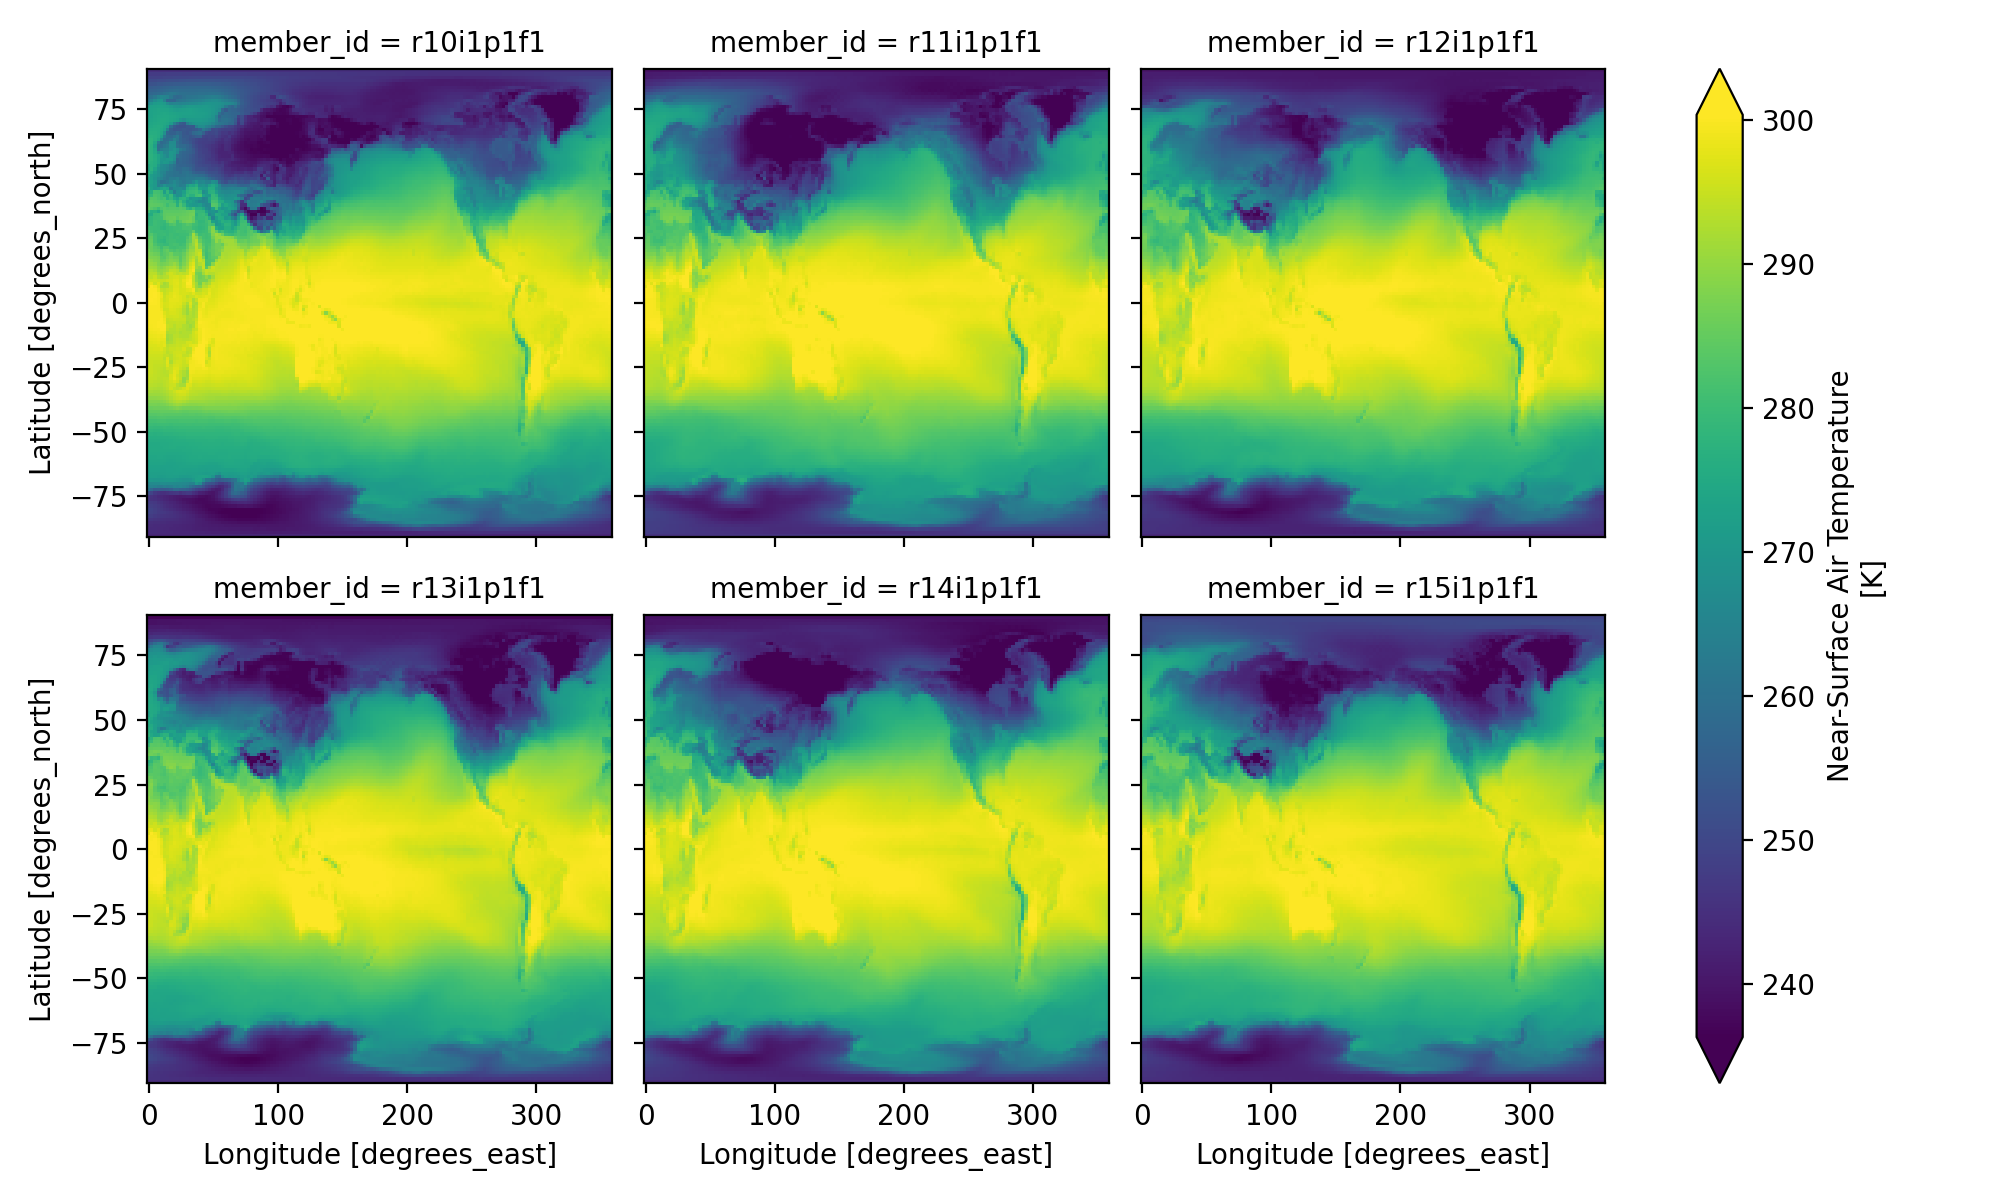

In [197]:
#Global historical Near-Surface Temperature Ensembles in 1958-01
model_historical_ds.tas.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("IPSL Global Distribution of Tas in 1958-01 in Historical Ensemble", y=1.1)

plt.savefig('images/Global_historical_tas_ensemble', bbox_inches='tight', dpi=300)

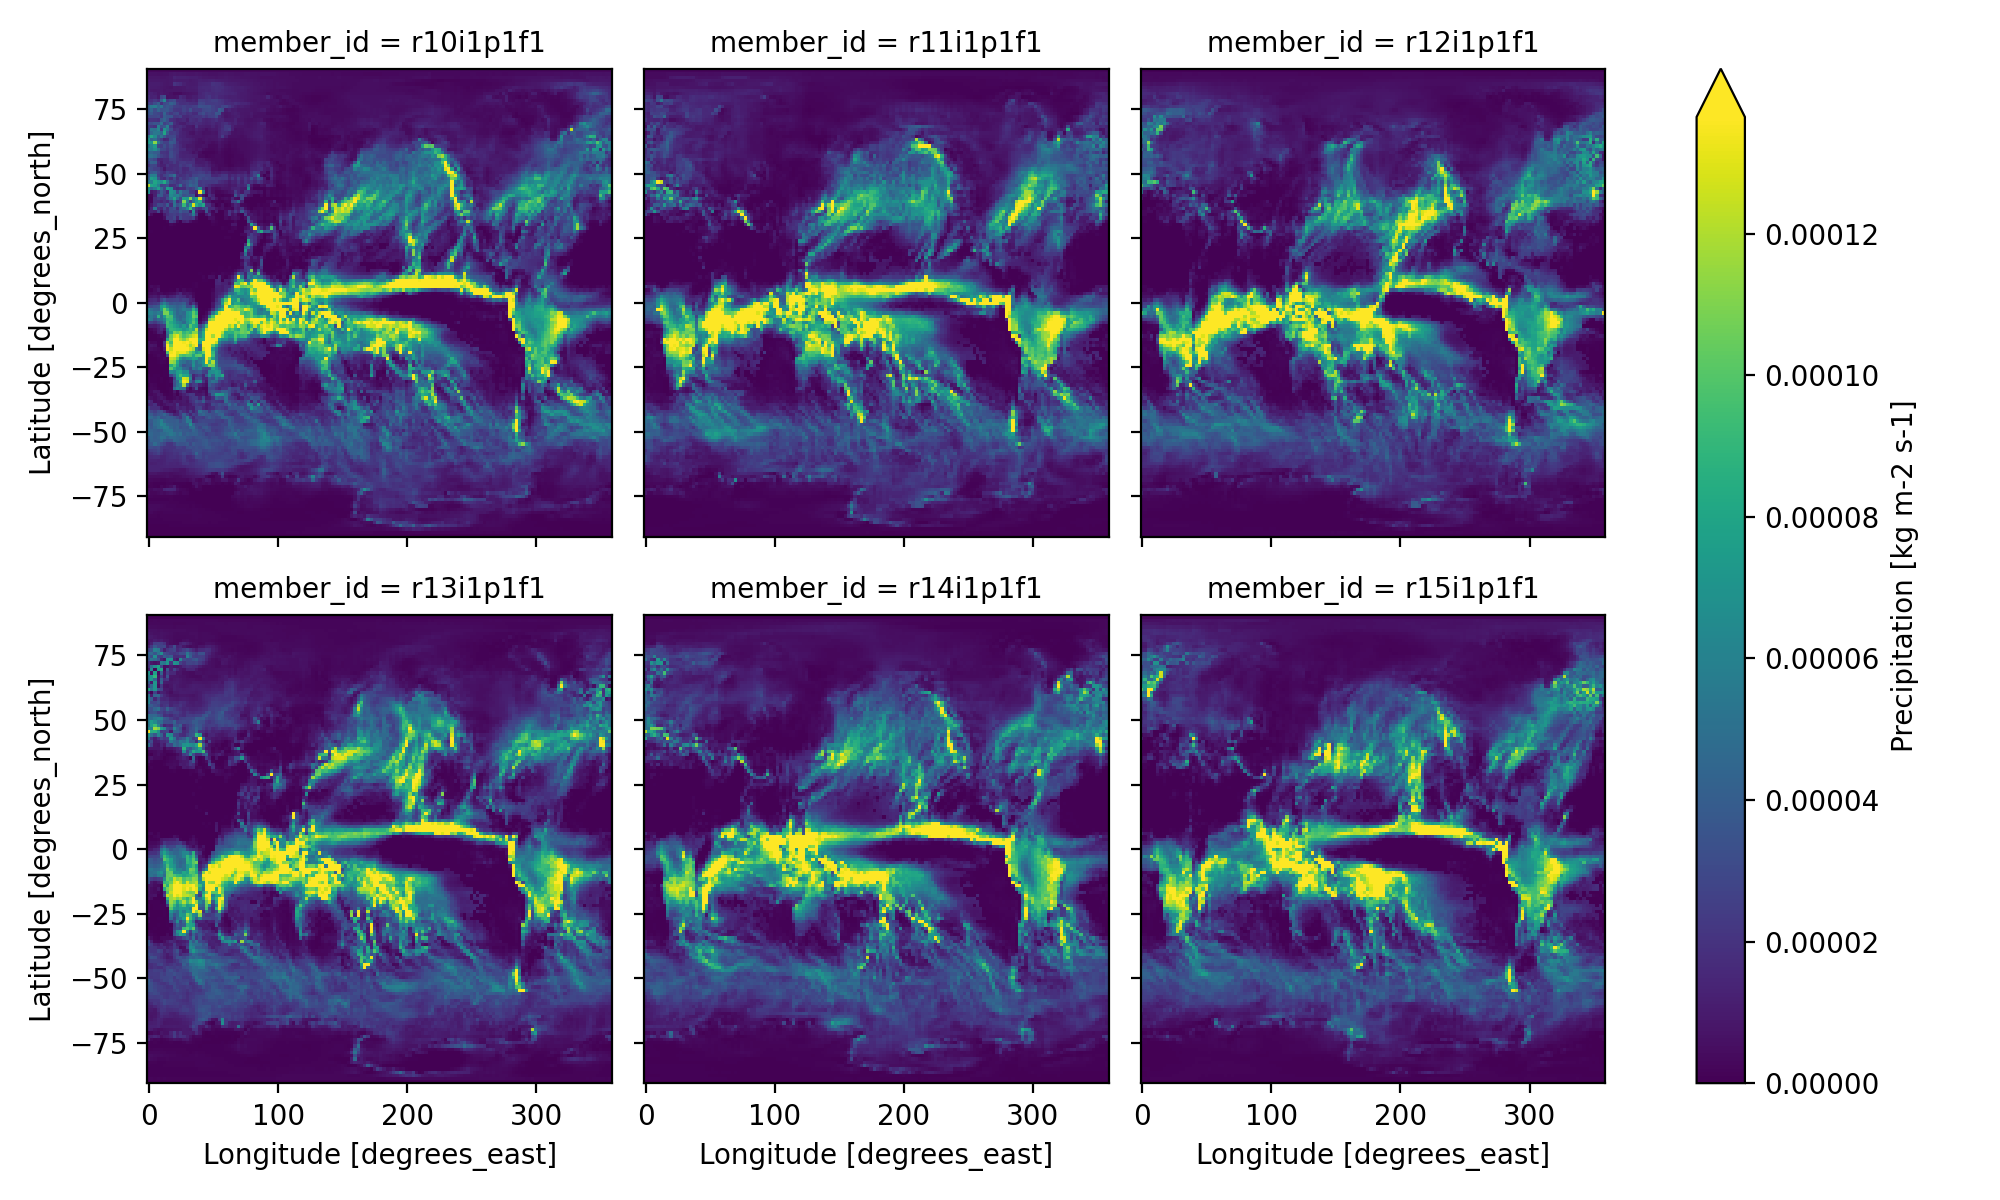

In [198]:
#Global historical Precipitation Flux Ensembles in 1958-01
model_historical_ds.pr.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("IPSL Global Distribution of Pr in 1958-01 in Historical Ensemble", y=1.1)

plt.savefig('images/Global_historical_pr_ensemble', bbox_inches='tight', dpi=300)

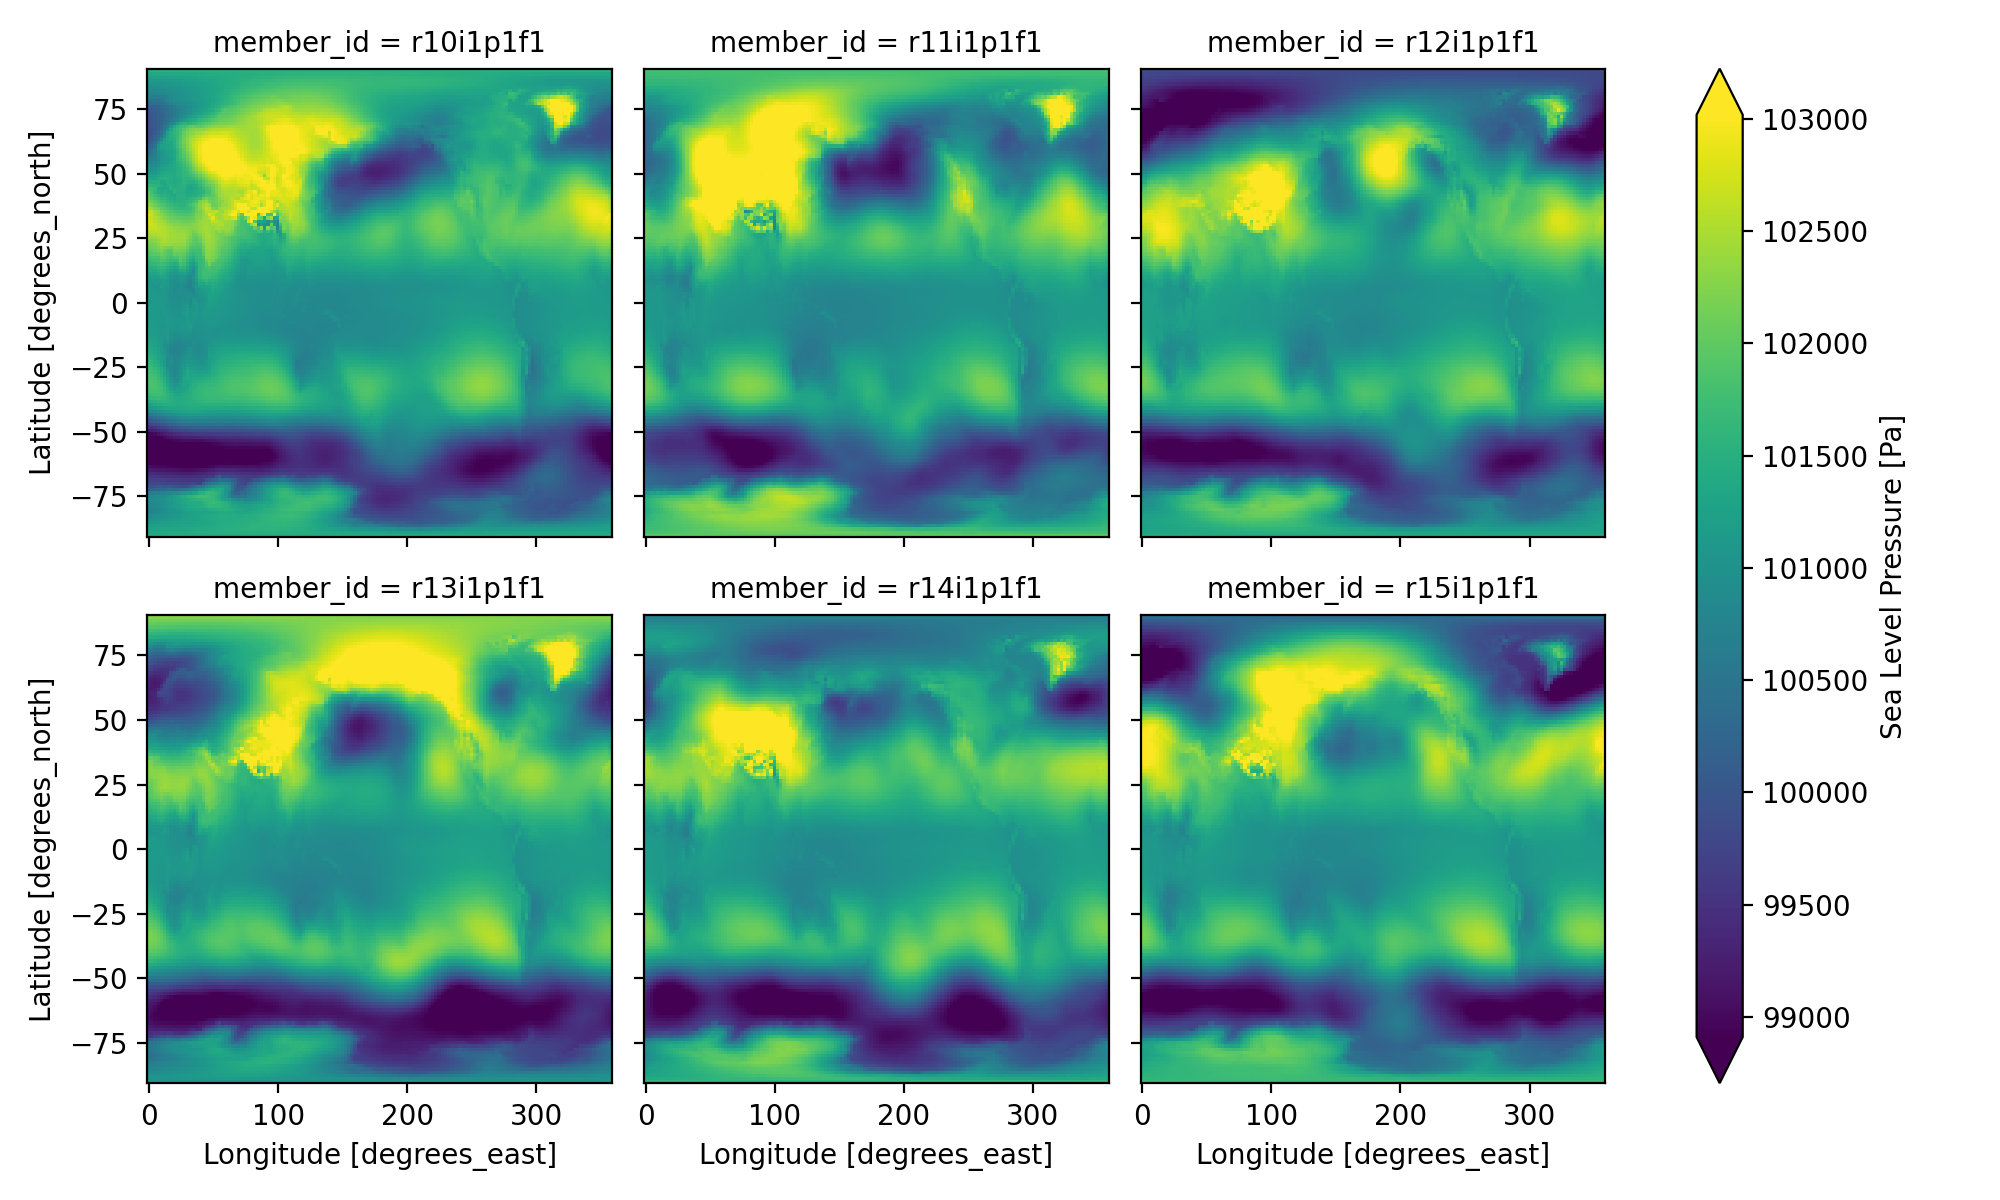

In [199]:
#Global historical Air Pressure at Sea Level Ensembles in 1958-01
model_historical_ds.psl.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("IPSL Global Distribution of Psl in 1958-01 in Historical Ensemble", y=1.1)

plt.savefig('images/Global_historical_psl_ensemble', bbox_inches='tight', dpi=300)

We now create some Robinson plots for the first ensemble member of each variable:

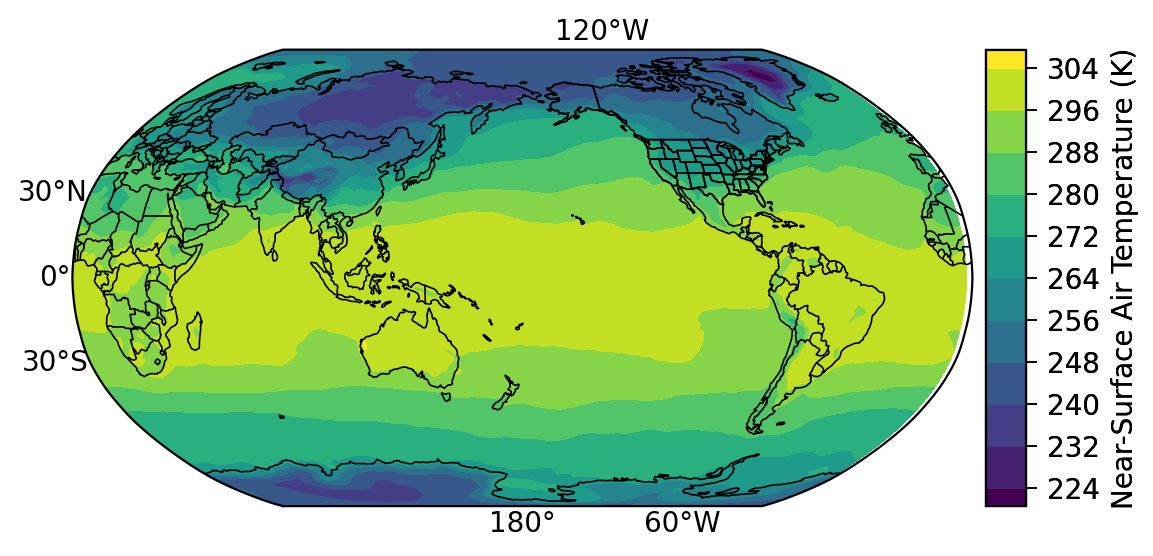

<Figure size 640x480 with 0 Axes>

In [28]:
#Create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 180},
)

#Format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

#Add contour variables
map1 = ax.contourf(model_historical_ds['lon'],
                   model_historical_ds['lat'],
                   #Choose ensemble member 0 and time 0
                   model_historical_ds['tas'][0, 0, :, :],
                   cmap='viridis',
                   extend='both')

#Add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Global_historical_tas_time0_member1', bbox_inches='tight', dpi=300)

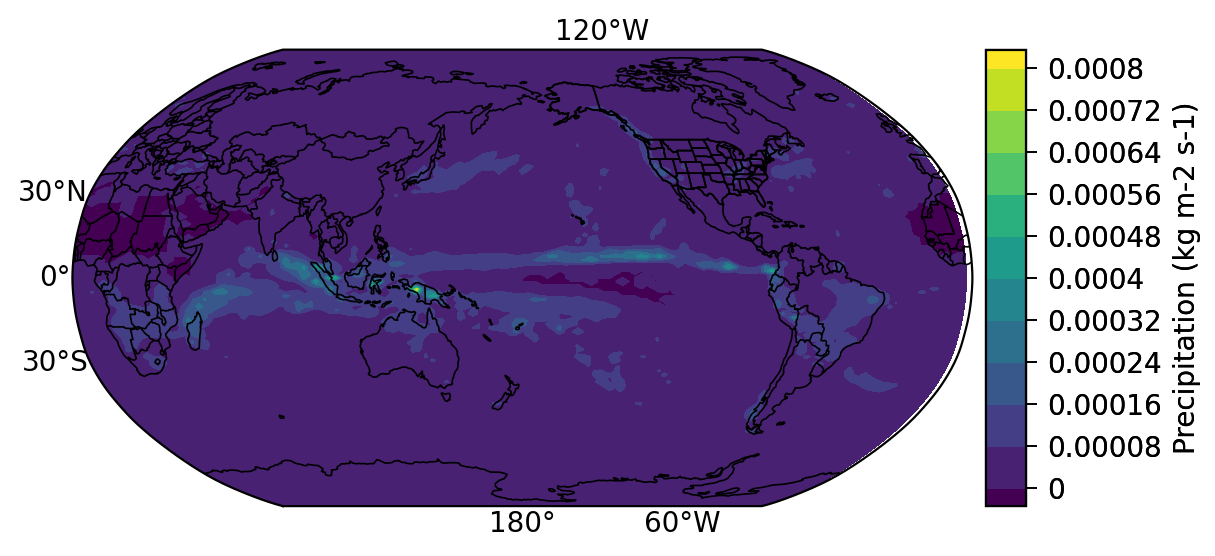

<Figure size 640x480 with 0 Axes>

In [29]:
#Create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 180},
)

#Format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

#Add contour variables
map1 = ax.contourf(model_historical_ds['lon'],
                   model_historical_ds['lat'],
                   #Choose ensemble member 0 and time 0
                   model_historical_ds['pr'][0, 0, :, :],
                   cmap='viridis',
                   extend='both')

#Add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Global_historical_pr_time0_member1', bbox_inches='tight', dpi=300)

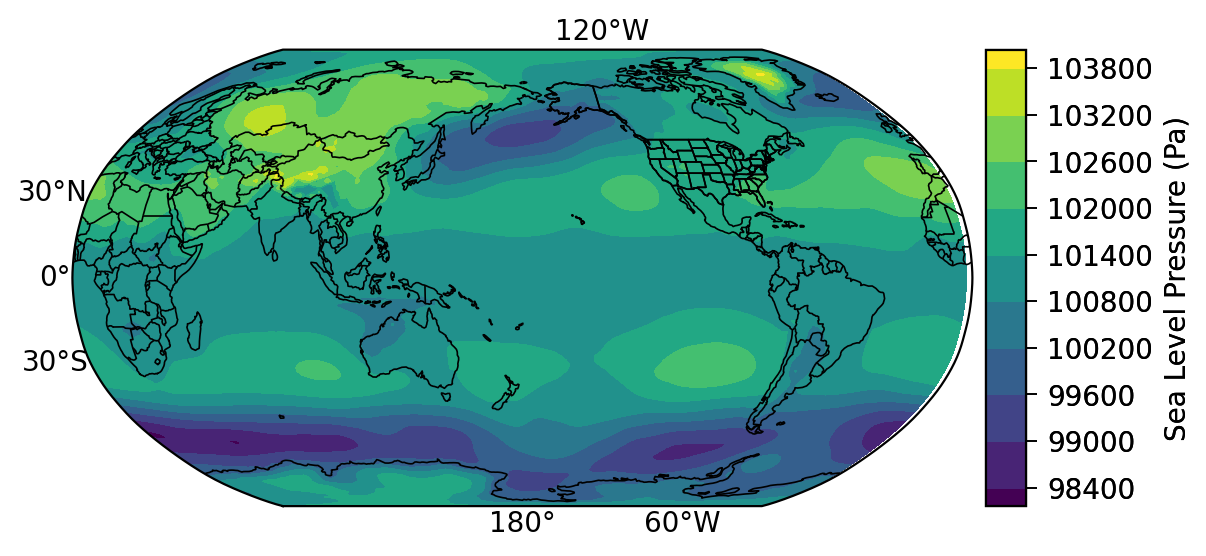

<Figure size 640x480 with 0 Axes>

In [30]:
#Create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 180},
)

#Format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

#Add contour variables
map1 = ax.contourf(model_historical_ds['lon'],
                   model_historical_ds['lat'],
                   #Choose ensemble member 0 and time 0
                   model_historical_ds['psl'][0, 0, :, :],
                   cmap='viridis',
                   extend='both')

#Add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Global_historical_psl_time0_member1', bbox_inches='tight', dpi=300)

### Australia

...and also an Australia based one:

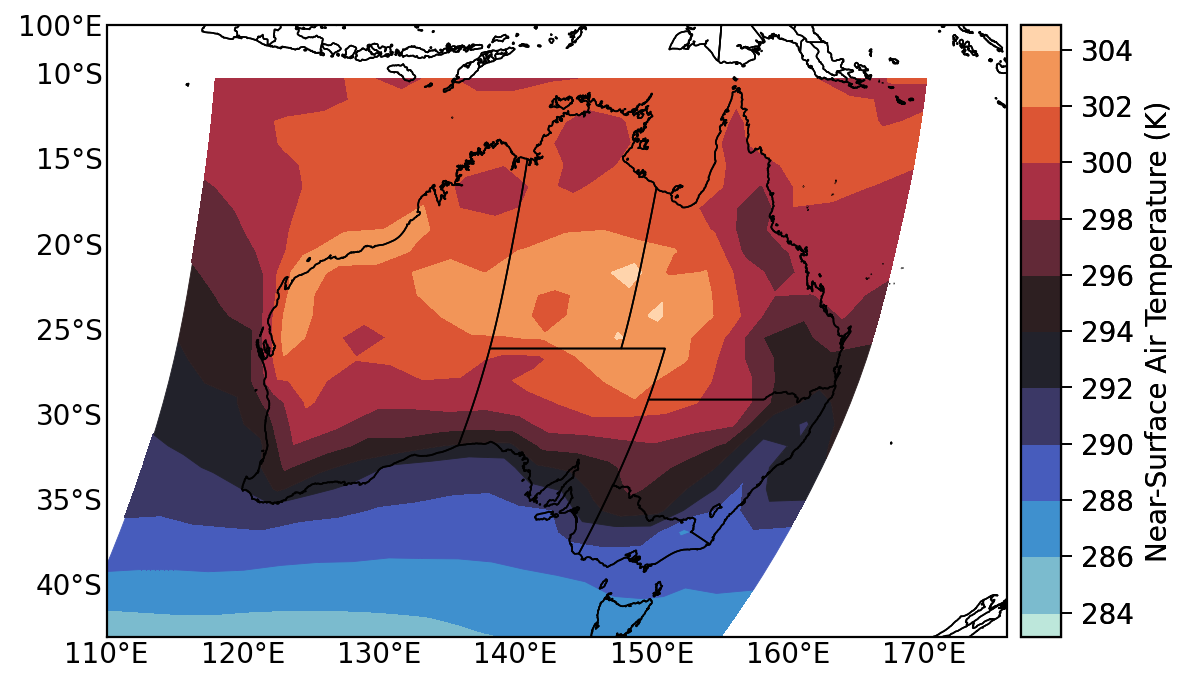

<Figure size 640x480 with 0 Axes>

In [23]:
#ensure the map is high quality
proplot.rc.reso = 'hi'

#create a Robinson projection with the proplot package
fig, ax = proplot.subplots(
    axwidth=4.5,
    tight=True,
    proj='robin',
    proj_kw={'lon_0': 0},
)

#format options
ax.format(
    land=False,
    coast=True,
    innerborders=True,
    borders=True,
    labels=True,
    geogridlinewidth=0,
)

ax[0].format(latlim=(-43, -7), lonlim=(110, 160), labels=True)

#add contour variables
map1 = ax.contourf(model_historical_A_tas_ds['lon'],
                   model_historical_A_tas_ds['lat'],
                   model_historical_A_tas_ds[0, 0, :, :],
                   cmap='IceFire',
                   extend='both')

#add a colorbar below
ax.colorbar(map1, loc='r', shrink=1, extendrect=True)

plt.show()

plt.savefig('images/Au_historical_tas', bbox_inches='tight', dpi=300)

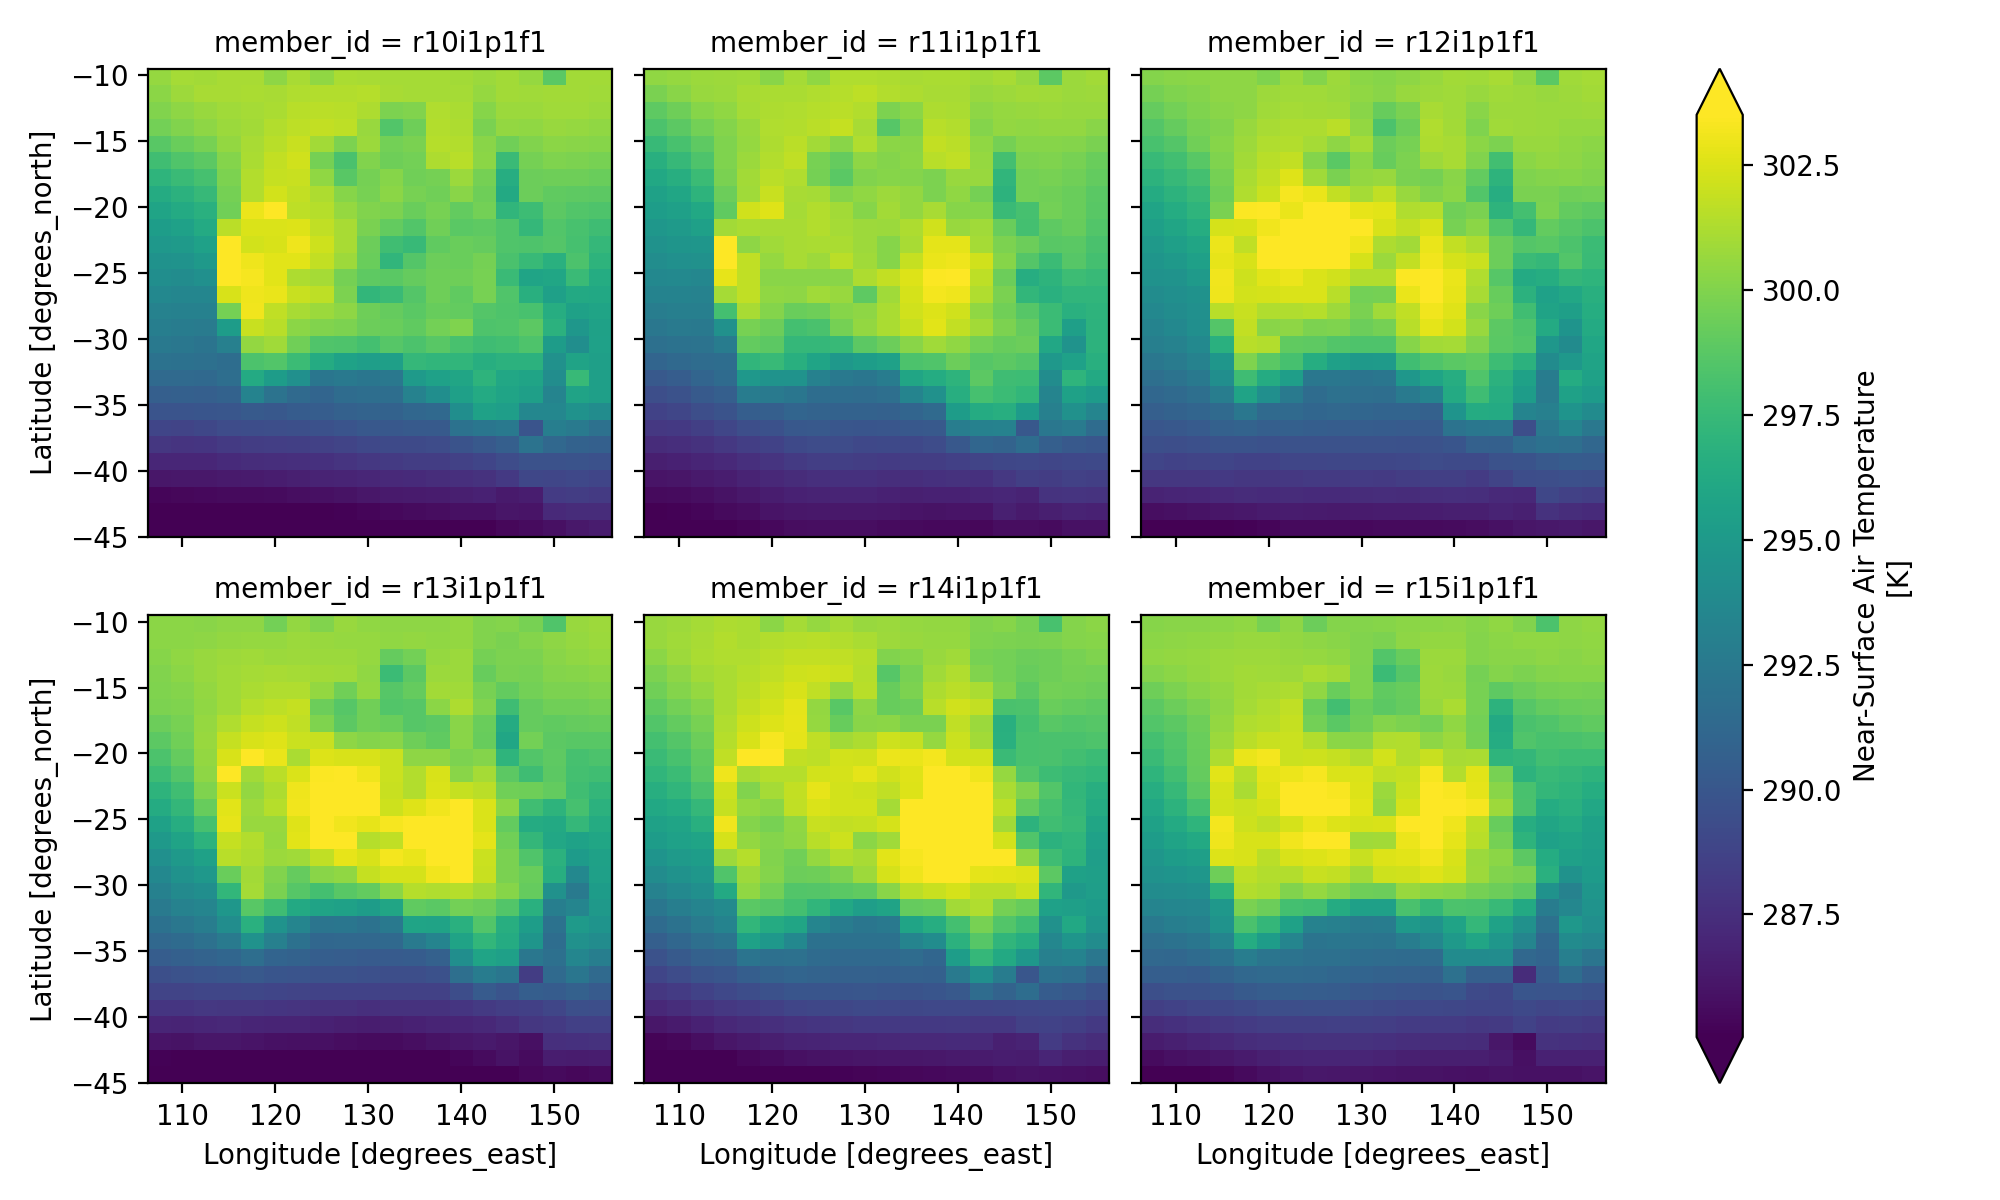

In [20]:
#Australia historical Near-Surface Temperature Ensembles in 1958-01
model_historical_A_tas_ds.isel(time=0, member_id=range(0, 6)).plot(col='member_id',
                                                          col_wrap=3,
                                                          robust=True)

plt.suptitle("IPSL Australia Distribution of Tas in 1958-01 in Historical Ensemble", x=0.45,y=1.03)

plt.savefig('images/ISPL_Au_historical_tas_ensemble.eps',format='eps', bbox_inches='tight', dpi=300)

# Creating Probability Distributions

We will use the following algorithm to generate a probability distribution for the tas variable in each experiment:
<br> (1): Match the time-span that each experiment covers.
<br> (2): Across the first ten years and the last ten years of the simulation, calculate the global mean tas for each member of the ensemble.
<br> (3): Calculate the difference in this mean.
<br> (4): Normalise the data and plot as a histogram.

## General Function

We create a function that calculates the mean difference in tas, or any other variable for that matter, given the starting time, final time, number of members in the ensemble, and the experiment type. 
<br>As this code normally takes a long time to run, we use parallelisation to speed this up. We also save the output array as a text file that we can load in after:

In [19]:
def change_mean(model, initialTime, totalTime, totalMembers, experiment, variable):
    
    #Calculate 10 years in months
    firstTenYears = range(initialTime, initialTime+12*10)
    lastTenYears = range(totalTime-12*10,totalTime)
    
    def _calculate_means(member):
        first_mean_var = np.mean(model[member, firstTenYears, :, :])
        last_mean_var = np.mean(model[member, lastTenYears, :, :])
        return first_mean_var, last_mean_var


    #Get the results (changing number of jobs to 1 for amip to 
    #prevent 'cannot pickle to workers' error)
    results = Parallel(n_jobs=1)(
        delayed(_calculate_means)(member) for member in range(totalMembers)
    )
    results = np.array(results)
    
    first_mean_var = results[:, 0]
    last_mean_var = results[:, 1]
    change_mean_var = last_mean_var - first_mean_var
    
    #Save the array as a txt file:
    np.savetxt('arrays/change_mean_'+experiment+'_'+variable+'.txt', change_mean_var)
    
    #Return the array as well
    return change_mean_var

## Historical Ensemble

In [37]:
totalTime = len(model_historical_A_tas_ds[0,:,0,0])

In [38]:
totalHistMembers = len(model_historical_A_tas_ds[:,0,0,0])

### Tas

In [39]:
%%time
change_mean_historical_tas = change_mean(model=model_historical_A_tas_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalHistMembers,
                                         experiment='historical',
                                         variable='tas')

Wall time: 8min 39s


Run the following code if you have already run the function above:

In [32]:
change_mean_historical_tas = np.loadtxt('arrays/change_mean_historical_tas.txt')

Now we have an array of the mean temperature change in each ensemble member:

In [33]:
change_mean_historical_tas

array([0.51821899, 0.68261719, 0.74899292, 0.72564697, 0.52401733,
       0.840271  , 0.86148071, 0.67150879, 0.74740601, 0.71548462,
       0.76889038, 0.65509033, 0.74935913, 0.55502319, 0.65353394,
       0.52700806, 0.37319946, 0.55993652, 0.5859375 , 0.5005188 ,
       0.55209351, 0.69775391, 0.61224365, 0.76843262, 0.64990234,
       0.56210327, 0.47998047, 0.59768677, 0.64282227, 0.77886963,
       0.71688843, 0.63903809])

In [68]:
sns.set_context("paper",
                rc={
                    "font.size": 20,
                    "axes.titlesize": 20,
                    "axes.labelsize": 20,
                    "xtick.labelsize": 12,
                    "ytick.labelsize": 12
                })

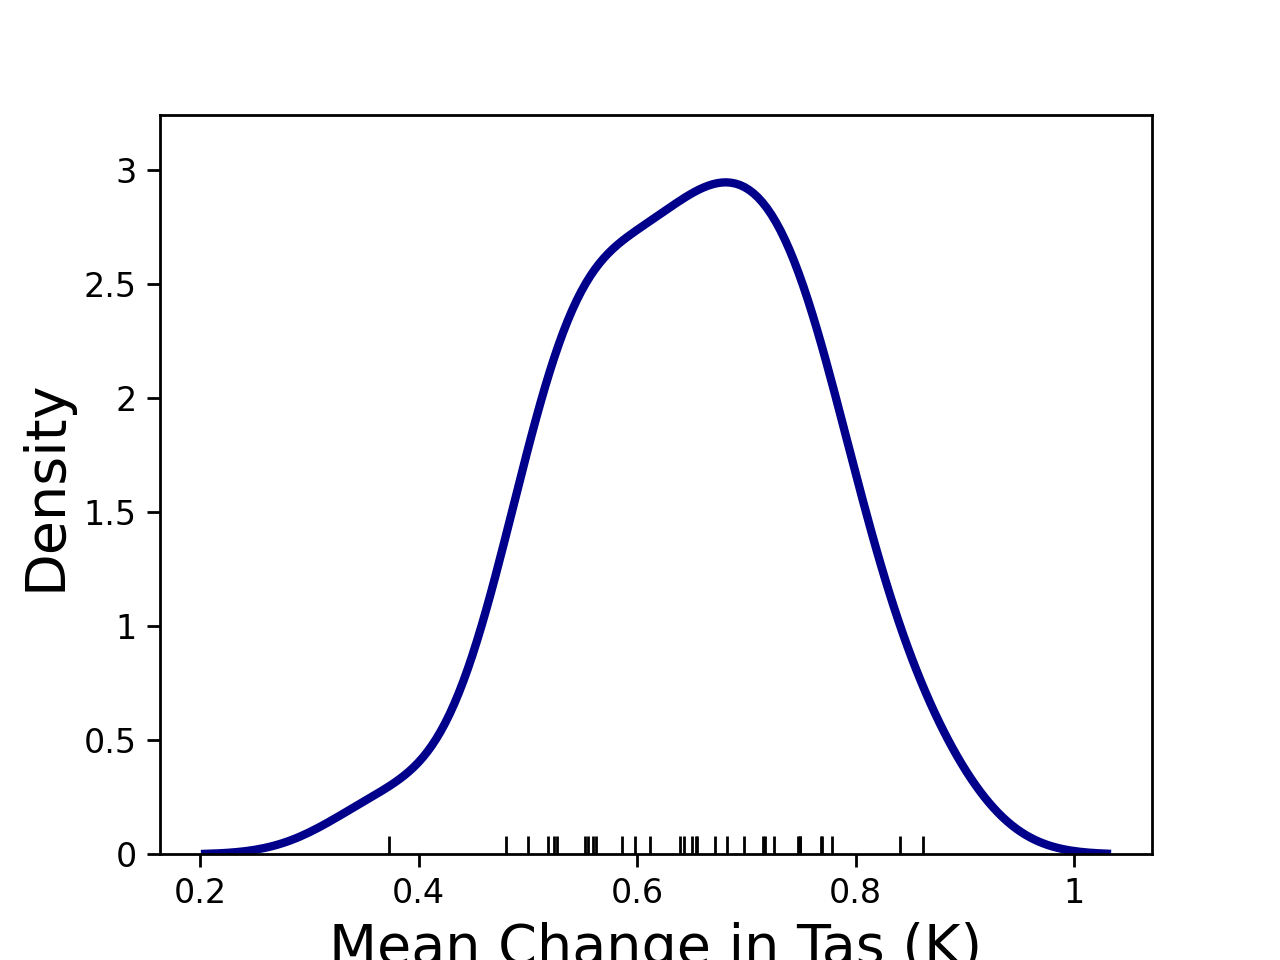

In [73]:
#Create a rug plot

sns.distplot(change_mean_historical_tas, hist=False, kde=True, rug=True, color='darkblue', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Tas (K)')
#plt.title('IPSL Historical Ensemble Distribution')
plt.savefig('images/Historical_ensemble_tas_dist_notitle.eps', format='eps', bbox_inches='tight')

### Pr

We repeat this process above for each of the other two variables pr and psl:

In [42]:
%%time
change_mean_historical_pr = change_mean(model=model_historical_A_pr_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalHistMembers,
                                         experiment='historical',
                                         variable='pr')

Wall time: 14min 45s


In [38]:
change_mean_historical_pr = np.loadtxt('arrays/change_mean_historical_pr.txt')

In [39]:
change_mean_historical_pr

array([ 6.06627509e-07, -5.12571205e-07,  7.03452315e-07,  3.20196705e-08,
        5.06661308e-08,  1.70328713e-06, -1.31859815e-06,  7.78672984e-07,
       -4.28190106e-08, -3.54108124e-07,  3.93614755e-07,  4.44706529e-07,
       -1.08837776e-06,  8.05574018e-07,  6.15324097e-07, -1.41255805e-06,
       -1.35059963e-07,  8.75334081e-07,  7.54915163e-07, -8.17228283e-07,
       -1.03704224e-06,  1.92175321e-06,  3.73474904e-08, -2.71435056e-07,
       -6.14563760e-07, -8.37819243e-07, -1.30558146e-06, -2.35599146e-07,
        9.72380803e-07,  1.70259955e-06, -4.79290975e-07, -7.39712050e-07])

We notice that these values are particularly small due to the units of $kg m^{-2}s^{-1}$, which will cause problems in the future. So, we scale up these values to $g m^{-2}d^{-1}$, which equates to scaling up by a value of:
$$ 1000 * (24 * 60^2) = 8.64 * 10^{7} $$

In [40]:
change_mean_historical_pr *= (8.63e7)
change_mean_historical_pr

array([  52.35195404,  -44.23489499,   60.70793479,    2.76329756,
          4.37248709,  146.99367894, -113.79502048,   67.19947851,
         -3.69528061,  -30.55953111,   33.96895336,   38.37817349,
        -93.92700049,   69.52103777,   53.10246961, -121.90375965,
        -11.65567483,   75.54133117,   65.14917859,  -70.52680085,
        -89.4967452 ,  165.84730201,    3.22308842,  -23.42484531,
        -53.03685248,  -72.3038007 , -112.67168029,  -20.33220626,
         83.91646334,  146.93434096,  -41.36281113,  -63.8371499 ])

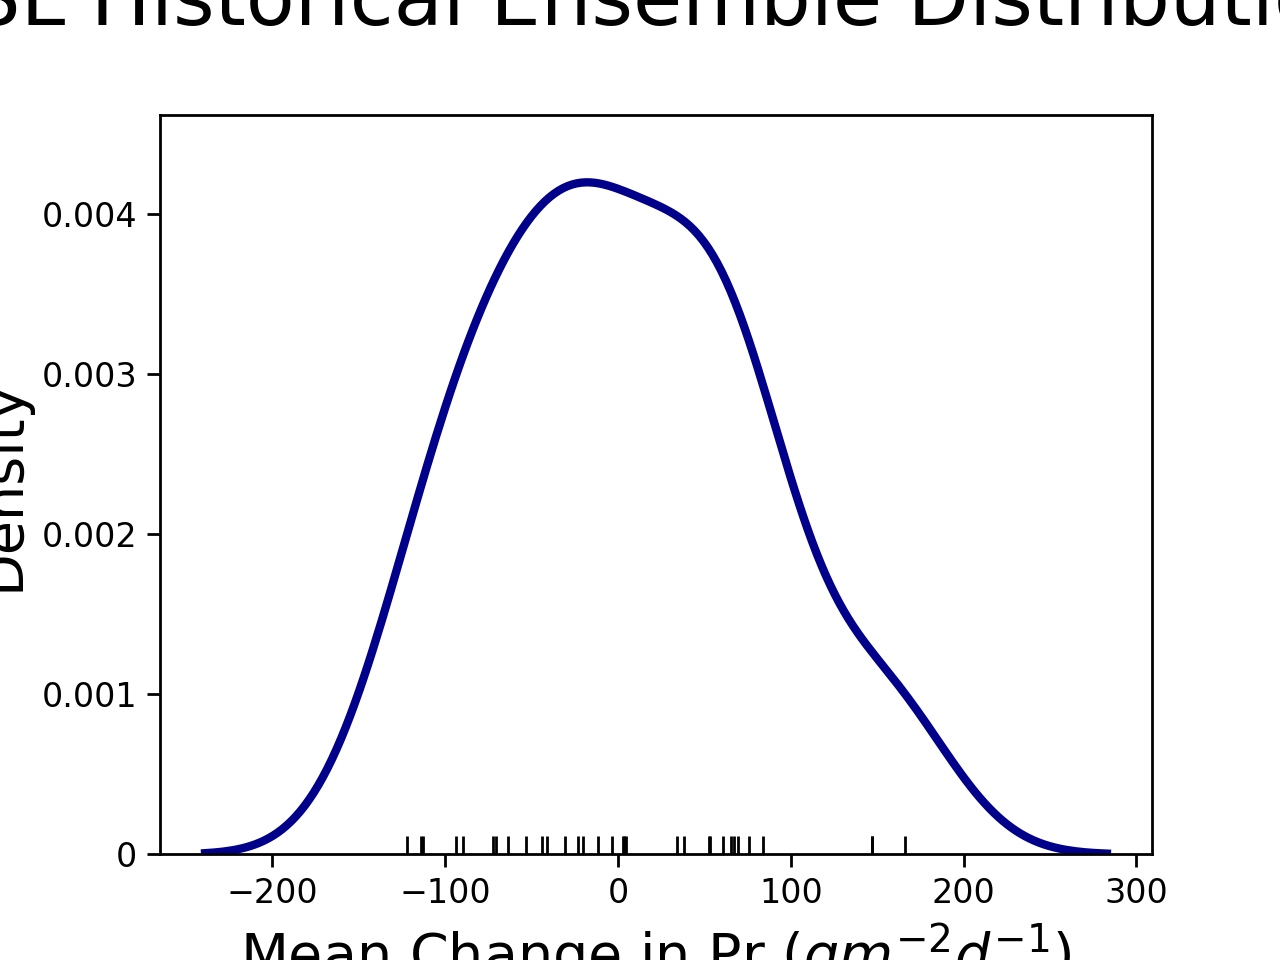

In [78]:
#Create a rug plot

sns.distplot(change_mean_historical_pr, hist=False, kde=True, rug=True, color='darkblue', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Pr ($g m^{-2} d^{-1}$)')
plt.title('IPSL Historical Ensemble Distributions', fontsize='x-large', y=1.1)
plt.savefig('images/Historical_ensemble_pr_dist.eps', format='eps', bbox_inches='tight')

### Psl

In [45]:
%%time
change_mean_historical_psl = change_mean(model=model_historical_A_psl_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalHistMembers,
                                         experiment='historical',
                                         variable='psl')

Wall time: 10min


In [44]:
change_mean_historical_psl = np.loadtxt('arrays/change_mean_historical_psl.txt')

In [45]:
change_mean_historical_psl

array([42.765625 , 26.5234375, 44.90625  ,  0.578125 , 33.3828125,
        4.0078125, 34.5859375, 35.9765625, 30.5078125, 17.03125  ,
       53.1796875, 25.3046875, 20.859375 , 28.125    , 16.265625 ,
       60.46875  , 27.9296875,  5.890625 , 28.7734375, 48.8125   ,
        9.8671875,  1.1015625, 23.265625 , 41.25     , 40.5546875,
        4.421875 , 61.6796875, 14.5546875, 20.78125  , 22.8671875,
       60.5078125, 46.7421875])

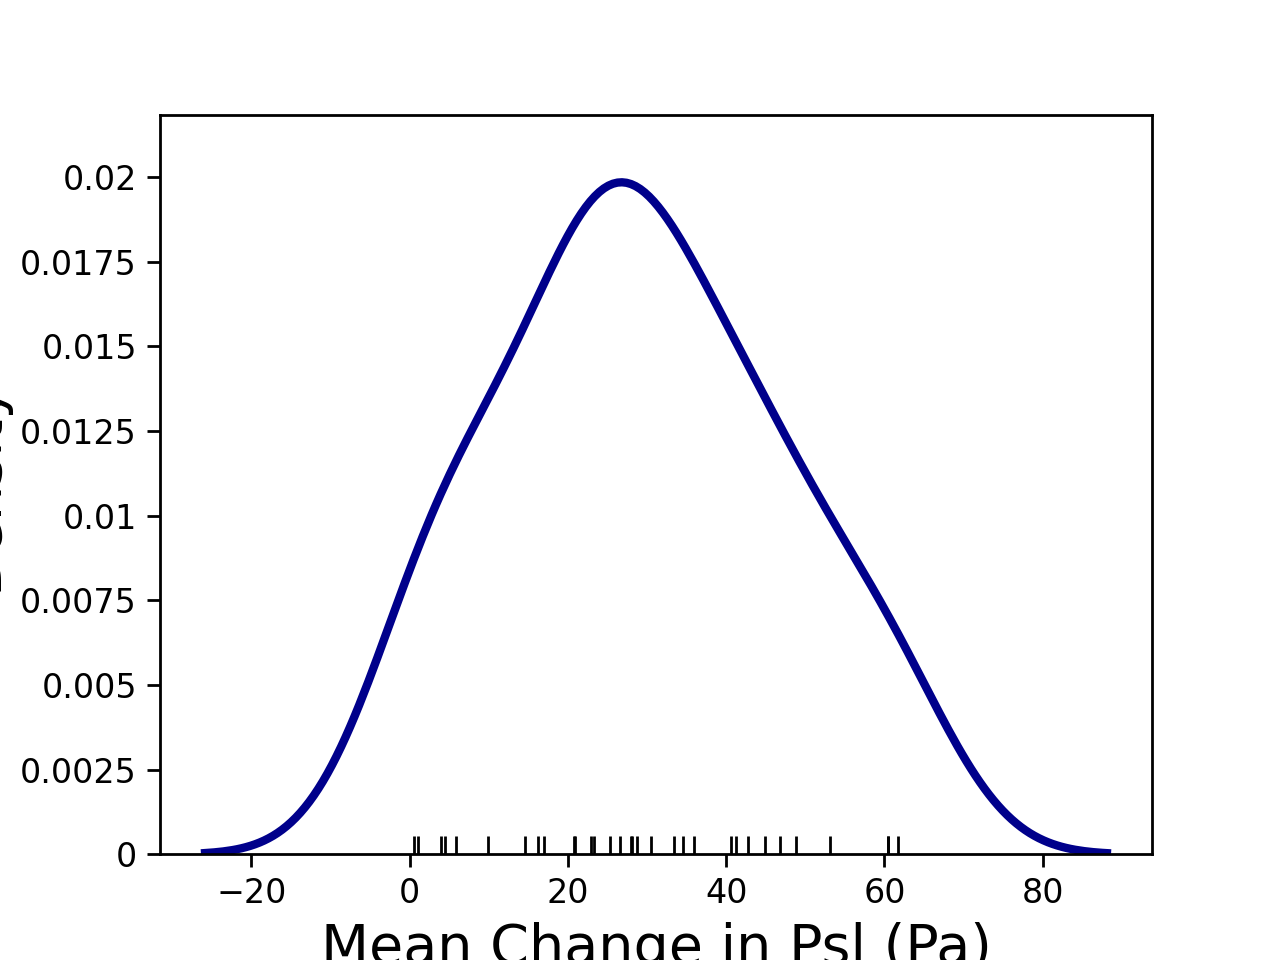

In [74]:
#Create a rug plot

sns.distplot(change_mean_historical_psl, hist=False, kde=True, rug=True, color='darkblue', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Psl (Pa)')
#plt.title('IPSL Historical Ensemble Distribution')
plt.savefig('images/Historical_ensemble_psl_dist_notitle.eps', format='eps', bbox_inches='tight')

## AMIP Ensemble

We repeat this for the AMIP ensemble.

### Tas

In [16]:
totalTime = len(model_amip_A_tas_ds[0,:,0,0])

In [17]:
totalAMIPMembers = len(model_amip_A_tas_ds[:,0,0,0])

In [20]:
%%time
change_mean_amip_tas = change_mean(model=model_amip_A_tas_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalAMIPMembers,
                                         experiment='amip',
                                         variable='tas')

Wall time: 2min 58s


Run the following code if you have already run the function above:

In [47]:
change_mean_amip_tas = np.loadtxt('arrays/change_mean_amip_tas.txt')

Now we have an array of the mean temperature change in each ensemble member:

In [48]:
#Remove nan values
change_mean_amip_tas = change_mean_amip_tas[~np.isnan(change_mean_amip_tas)]
change_mean_amip_tas

array([0.56347656, 0.57113647, 0.60757446, 0.6227417 , 0.69308472,
       0.52865601, 0.63839722, 0.6161499 , 0.62033081, 0.58099365,
       0.58456421, 0.57937622, 0.65951538, 0.53436279, 0.57781982,
       0.5546875 , 0.59994507, 0.62335205, 0.59292603, 0.55157471])

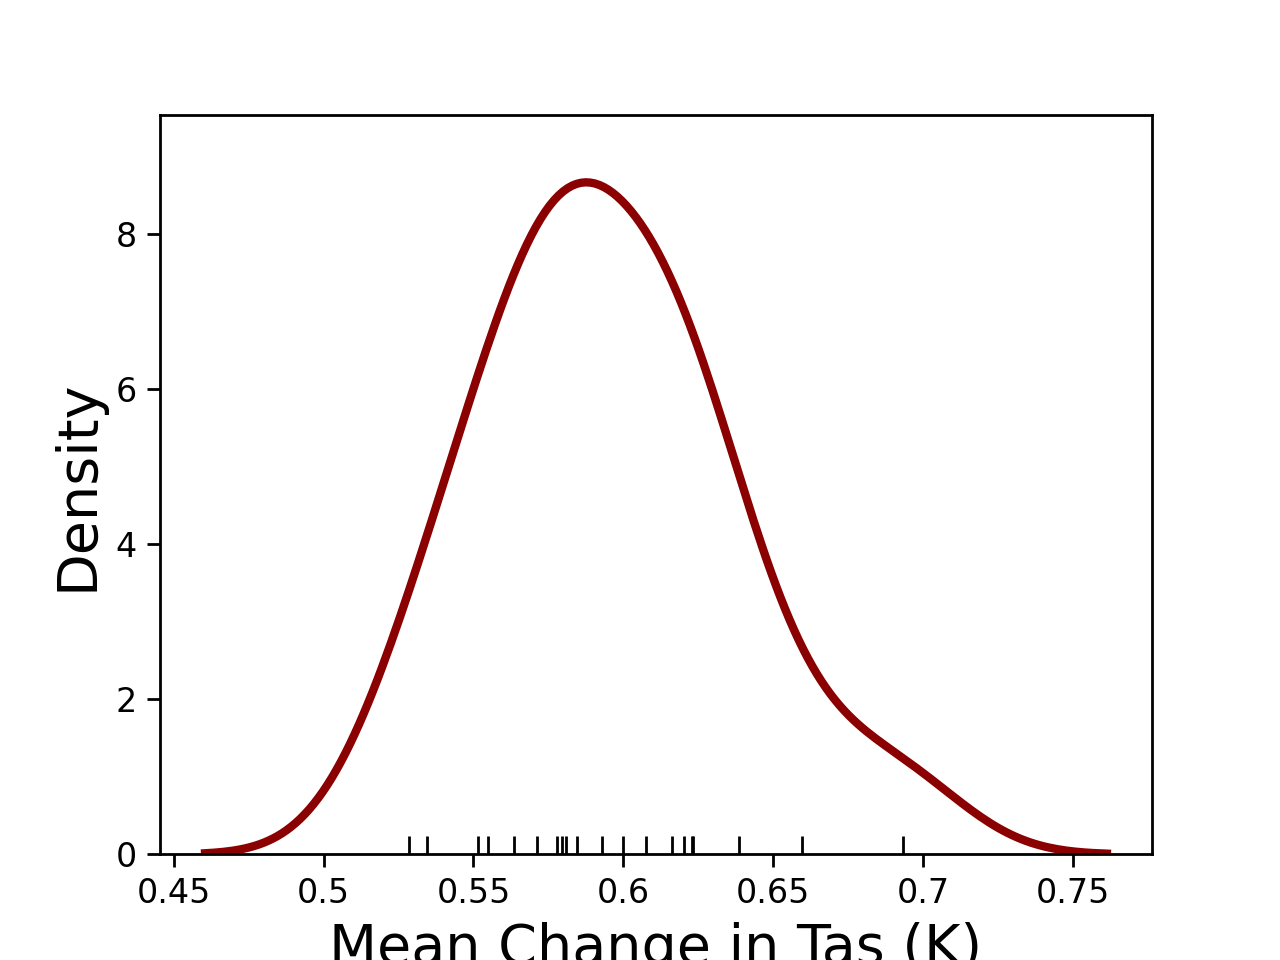

In [75]:
#Create a rug plot

sns.distplot(change_mean_amip_tas, hist=False, kde=True, rug=True, color='darkred', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Tas (K)')
#plt.title('IPSL AMIP Ensemble Distribution')
plt.savefig('images/AMIP_ensemble_tas_dist_notitle.eps', format='eps', bbox_inches='tight')

### Pr

In [23]:
%%time
change_mean_amip_pr = change_mean(model=model_amip_A_pr_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalAMIPMembers,
                                         experiment='amip',
                                         variable='pr')

Wall time: 3min 32s


In [50]:
change_mean_amip_pr = np.loadtxt('arrays/change_mean_amip_pr.txt')

In [51]:
#Remove nan values
change_mean_amip_pr = change_mean_amip_pr[~np.isnan(change_mean_amip_pr)]
change_mean_amip_pr

array([-3.31092451e-08,  1.04910214e-06,  8.45409886e-07,  9.45479769e-07,
       -4.70827217e-07, -8.49868229e-08,  4.81859388e-07, -1.06097650e-06,
       -4.52861059e-07,  6.93093170e-07,  9.07763024e-07, -3.07667506e-07,
       -6.08179107e-08,  9.14242264e-07, -1.31494744e-07,  1.08508175e-06,
        1.28273314e-07,  2.31422746e-07,  1.25430233e-07,  1.07107007e-06])

We notice that these values are particularly small due to the units of $kg m^{-2}s^{-1}$, which will cause problems in the future. So, we scale up these values to $g m^{-2}d^{-1}$, which equates to scaling up by a value of:
$$ 1000 * (24 * 60^2) = 8.64 * 10^{7} $$

In [52]:
change_mean_amip_pr *= (8.63e7)
change_mean_amip_pr

array([ -2.85732785,  90.53751455,  72.95887317,  81.59490408,
       -40.63238885,  -7.33436282,  41.58446518, -91.56227206,
       -39.08190938,  59.81394061,  78.33994896, -26.55170574,
        -5.24858569,  78.89910739, -11.34799641,  93.64255493,
        11.06998698,  19.97178297,  10.82462913,  92.43334734])

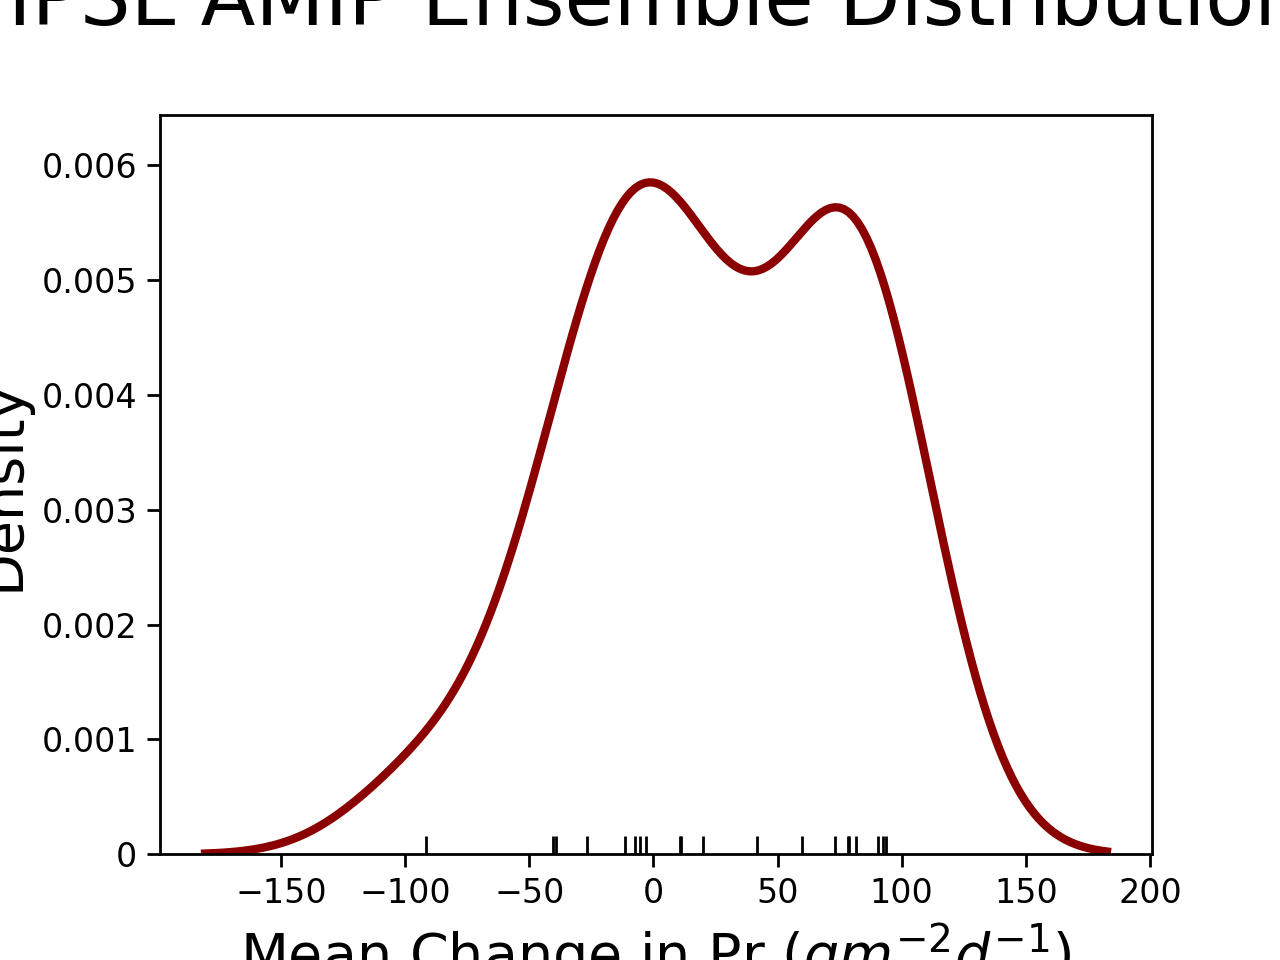

In [80]:
#Create a rug plot

sns.distplot(change_mean_amip_pr, hist=False, kde=True, rug=True, color='darkred', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Pr ($g m^{-2} d^{-1}$)')
plt.title('IPSL AMIP Ensemble Distribution', fontsize='x-large', y=1.1)
plt.savefig('images/AMIP_ensemble_pr_dist.eps', format='eps', bbox_inches='tight')

### Psl

In [26]:
%%time
change_mean_amip_psl = change_mean(model=model_amip_A_psl_ds,
                                         initialTime=0,
                                         totalTime=totalTime,
                                         totalMembers=totalAMIPMembers,
                                         experiment='amip',
                                         variable='psl')

Wall time: 2min 29s


In [54]:
change_mean_amip_psl = np.loadtxt('arrays/change_mean_amip_psl.txt')

In [55]:
#Remove nan values
change_mean_amip_psl = change_mean_amip_psl[~np.isnan(change_mean_amip_psl)]
change_mean_amip_psl

array([-39.6328125, -36.6875   , -48.34375  , -49.296875 , -40.9921875,
       -19.8359375, -42.890625 , -64.65625  , -26.0625   , -35.2109375,
       -28.5859375,  -8.140625 , -36.109375 , -28.203125 , -41.4453125,
       -31.609375 , -42.3125   , -22.2734375, -46.6171875, -34.0234375])

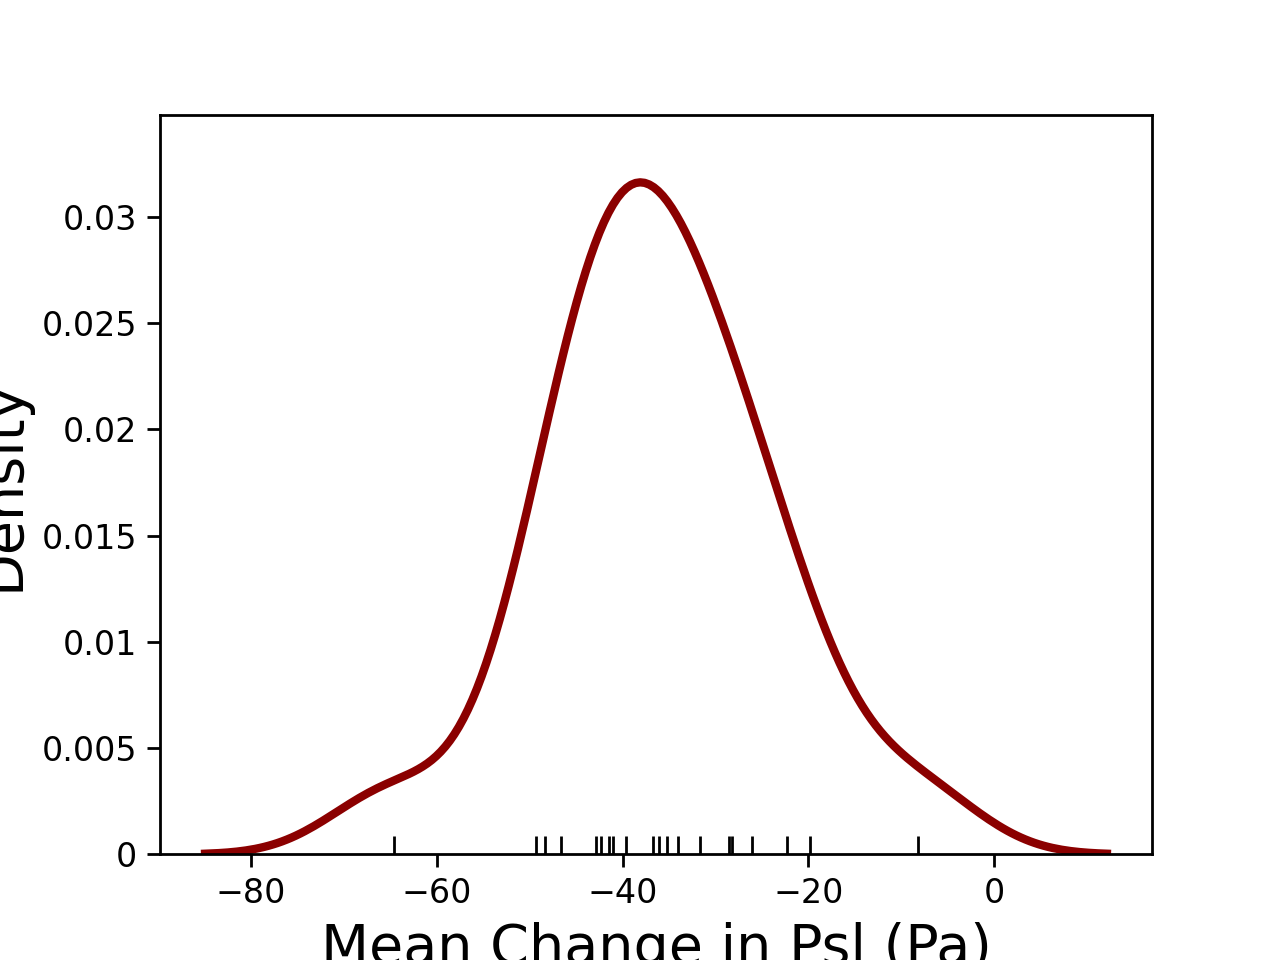

In [77]:
#Create a rug plot 

sns.distplot(change_mean_amip_psl, hist=False, kde=True, rug=True, color='darkred', 
            kde_kws={'linewidth': 3}, rug_kws={'color': 'black'})

plt.xlabel('Mean Change in Psl (Pa)')
#plt.title('IPSL AMIP Ensemble Distribution')
plt.savefig('images/AMIP_ensemble_psl_dist_notitle.eps', format='eps', bbox_inches='tight')

# Calculating Distances in 3D

In [2]:
#Mathematical and statistical packages
import math
import scipy

#KL
from scipy.stats import entropy

#JS
from scipy.spatial.distance import jensenshannon

#Wasserstein
import ot
import ot.plot

#Energy
import dcor

## Creating Joint Distribution

We re-apply the process above, but for all three variables at once. Hence we need to create the two three-variate array distributions for a distance to be calculated:

In [14]:
historical_outputs = np.dstack([change_mean_historical_tas, change_mean_historical_pr, change_mean_historical_psl])[0,:,:]
historical_outputs.shape

(32, 3)

In [36]:
amip_outputs = np.dstack([change_mean_amip_tas, change_mean_amip_pr, change_mean_amip_psl])[0,:,:]
amip_outputs.shape

(20, 3)

We see that these both have shape (number of amip ensembles, number of variables).

In [16]:
np.savetxt('arrays/all_historical_outputs.txt', historical_outputs)

In [21]:
historical_outputs = np.loadtxt('arrays/all_historical_outputs.txt')
historical_outputs

array([[   0.51821899,   52.35195404,   42.765625  ],
       [   0.68261719,  -44.23489499,   26.5234375 ],
       [   0.74899292,   60.70793479,   44.90625   ],
       [   0.72564697,    2.76329756,    0.578125  ],
       [   0.52401733,    4.37248709,   33.3828125 ],
       [   0.840271  ,  146.99367894,    4.0078125 ],
       [   0.86148071, -113.79502048,   34.5859375 ],
       [   0.67150879,   67.19947851,   35.9765625 ],
       [   0.74740601,   -3.69528061,   30.5078125 ],
       [   0.71548462,  -30.55953111,   17.03125   ],
       [   0.76889038,   33.96895336,   53.1796875 ],
       [   0.65509033,   38.37817349,   25.3046875 ],
       [   0.74935913,  -93.92700049,   20.859375  ],
       [   0.55502319,   69.52103777,   28.125     ],
       [   0.65353394,   53.10246961,   16.265625  ],
       [   0.52700806, -121.90375965,   60.46875   ],
       [   0.37319946,  -11.65567483,   27.9296875 ],
       [   0.55993652,   75.54133117,    5.890625  ],
       [   0.5859375 ,   65.

In [37]:
np.savetxt('arrays/all_amip_outputs.txt', amip_outputs)

In [22]:
amip_outputs = np.loadtxt('arrays/all_amip_outputs.txt')
amip_outputs

array([[  0.56347656,  -2.85732785, -39.6328125 ],
       [  0.57113647,  90.53751455, -36.6875    ],
       [  0.60757446,  72.95887317, -48.34375   ],
       [  0.6227417 ,  81.59490408, -49.296875  ],
       [  0.69308472, -40.63238885, -40.9921875 ],
       [  0.52865601,  -7.33436282, -19.8359375 ],
       [  0.63839722,  41.58446518, -42.890625  ],
       [  0.6161499 , -91.56227206, -64.65625   ],
       [  0.62033081, -39.08190938, -26.0625    ],
       [  0.58099365,  59.81394061, -35.2109375 ],
       [  0.58456421,  78.33994896, -28.5859375 ],
       [  0.57937622, -26.55170574,  -8.140625  ],
       [  0.65951538,  -5.24858569, -36.109375  ],
       [  0.53436279,  78.89910739, -28.203125  ],
       [  0.57781982, -11.34799641, -41.4453125 ],
       [  0.5546875 ,  93.64255493, -31.609375  ],
       [  0.59994507,  11.06998698, -42.3125    ],
       [  0.62335205,  19.97178297, -22.2734375 ],
       [  0.59292603,  10.82462913, -46.6171875 ],
       [  0.55157471,  92.43334

## Visualisation of the Joint Outputs

Let's see these outputs in a 3D projection plot:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

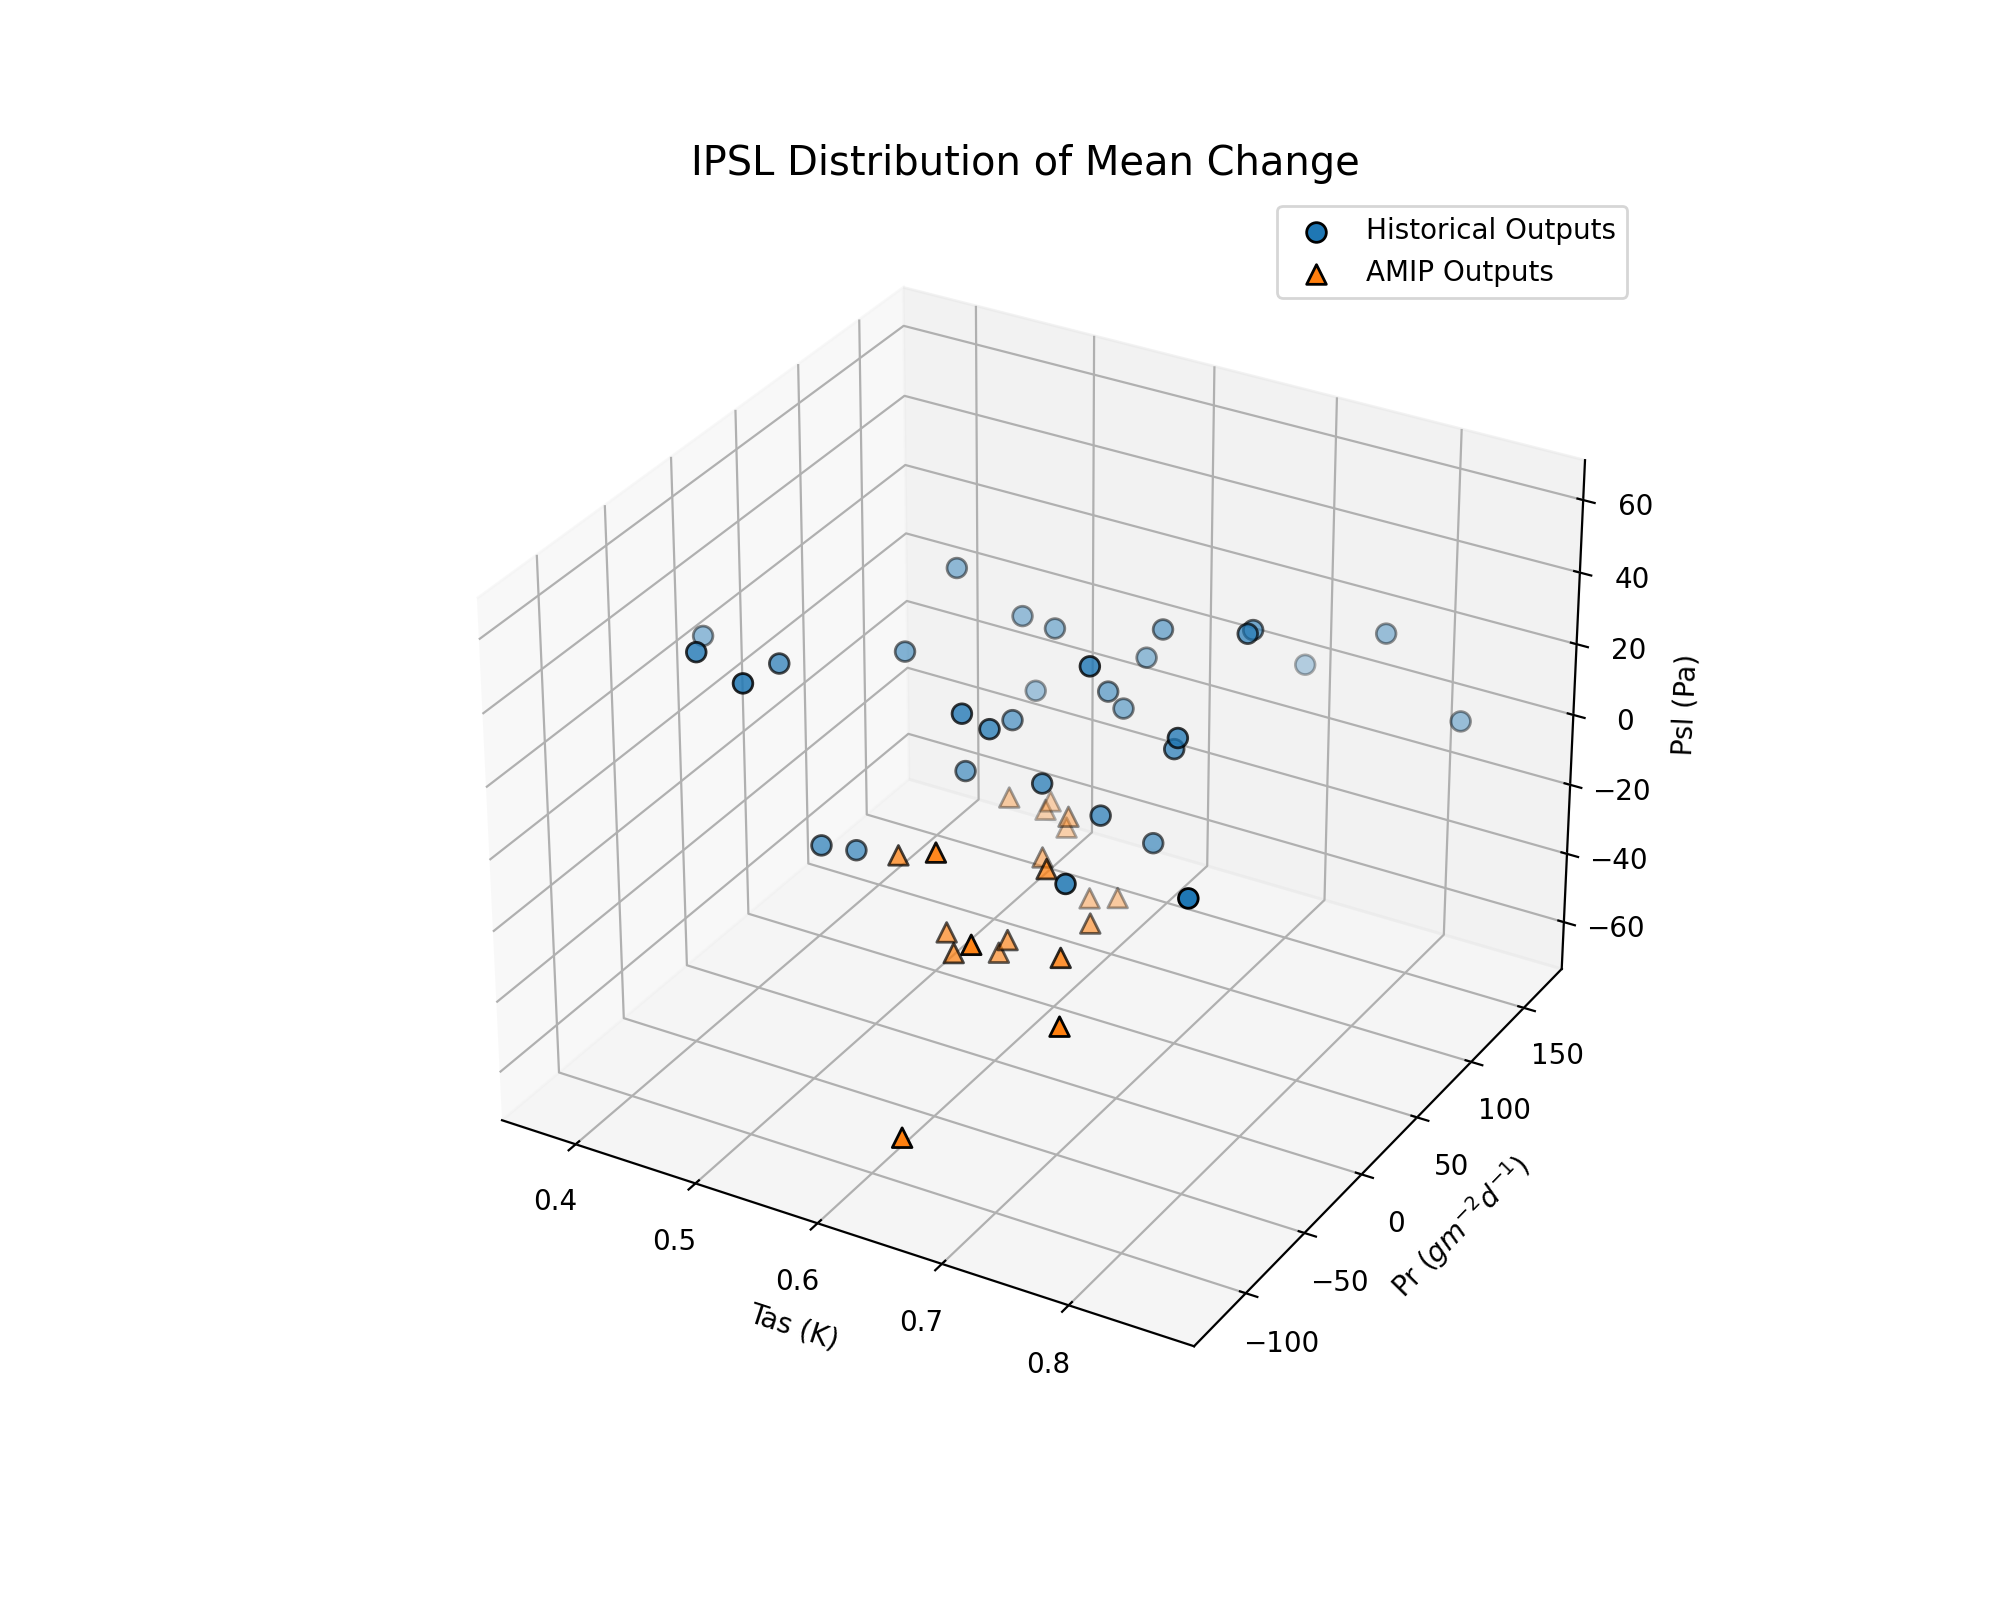

In [31]:
fig = plt.figure(figsize=(10,8))

#Make 3D projection
ax = plt.axes(projection='3d')
ax.scatter3D(historical_outputs[:,0], historical_outputs[:,1], historical_outputs[:,2], s=50, cmap='Greens', edgecolor='black', label='Historical Outputs')
ax.scatter3D(amip_outputs[:,0], amip_outputs[:,1], amip_outputs[:,2], s=50, cmap='Reds', marker= '^', edgecolor='black', label='AMIP Outputs')

ax.set_xlabel('Tas (K)')
ax.set_ylabel('Pr ($g m^{-2} d^{-1}$)')
ax.set_zlabel('Psl (Pa)')

ax.set_title('IPSL Distribution of Mean Change', fontsize='x-large')
plt.legend()
plt.savefig('images/Tas_pr_prt_dist.eps', format='eps', bbox_inches='tight', dpi=300)

## Fitting a 3D Multivariate Gaussian to the Distributions

This will be necessary in order to calculate KL divergence (and JS distance) in a sensible way, as unlike Wasserstein and energy distance, KL divergence requires a 1D pdf for each measure, with a shared support (this is one of the limitations of KL divergence!). 

In [39]:
from scipy.stats import multivariate_normal

### Mean and Covariance

In [40]:
amip_mean = np.mean(amip_outputs, axis=0)
amip_cov = np.cov(amip_outputs, rowvar=0)

In [109]:
amip_mean

array([  0.59503326,  25.35272532, -36.14648438])

In [110]:
amip_cov

array([[ 1.71116911e-03, -8.88723826e-01, -1.79017409e-01],
       [-8.88723826e-01,  2.91728936e+03,  6.94259224e+01],
       [-1.79017409e-01,  6.94259224e+01,  1.51705032e+02]])

In [41]:
historical_mean = np.mean(historical_outputs, axis=0)
historical_cov = np.cov(historical_outputs, rowvar=0)

In [112]:
historical_mean

array([ 0.64568615,  3.22522235, 29.17089844])

In [113]:
historical_cov

array([[ 1.26356855e-02,  2.05362840e+00, -2.79538775e-01],
       [ 2.05362840e+00,  6.08906039e+03, -5.64730178e+02],
       [-2.79538775e-01, -5.64730178e+02,  3.10468855e+02]])

### Analysing the Gaussian

In [133]:
amip_gaussian = multivariate_normal.pdf(amip_outputs, mean=amip_mean, cov=amip_cov)

This gives us a 1D array of probabilities which can be used for KL divergence calculation:

In [115]:
amip_gaussian

array([1.10168418e-03, 1.25958862e-03, 9.43515482e-04, 5.50742590e-04,
       1.39316386e-04, 2.22363634e-04, 1.12858865e-03, 1.44454553e-05,
       7.42308502e-04, 2.18306651e-03, 1.37176197e-03, 9.80609569e-05,
       6.68681455e-04, 8.20514564e-04, 1.30241346e-03, 1.05635423e-03,
       2.29026619e-03, 7.10296691e-04, 1.64091786e-03, 1.01883877e-03])

There's no nice way of visualising the actual Gaussian pdf, as it would be in 4D. The only 'sensible' way would be to look at 3D contour plots, but a 3D contour of a Gaussian are ellipsoids (3D ellipses), which is probably complicated to code and not very helpful visually.

We repeat this process for the historical outputs:

In [118]:
historical_gaussian = multivariate_normal.pdf(historical_outputs, 
                                              mean=historical_mean, cov=historical_cov)

This gives us a 1D array of probabilities which can be used for KL divergence calculation:

In [119]:
historical_gaussian

array([9.06379464e-05, 3.14729582e-04, 1.05621886e-04, 7.70432556e-05,
       2.43141179e-04, 2.78028997e-05, 9.61584376e-06, 2.41389216e-04,
       2.92533914e-04, 2.11121719e-04, 5.67632608e-05, 4.18853651e-04,
       5.85155492e-05, 1.82922968e-04, 3.29325981e-04, 4.93645107e-05,
       2.18767738e-05, 1.00990557e-04, 2.46956408e-04, 1.23013559e-04,
       4.07880638e-05, 3.80708787e-05, 4.11414920e-04, 1.70260417e-04,
       3.23603012e-04, 3.37149415e-05, 3.39292252e-05, 2.34941350e-04,
       2.61122840e-04, 5.62516068e-05, 6.40371573e-05, 2.45787180e-04])

## KL Divergence

As the probability arrays have different lengths, we randomly select the 'matching' number of elements from the historical probabilities array, calculate the KL divergence, then repeat many times in order to calculate the average KL score.

In [120]:
def uneven_arrays(p,q): 
    #Match the array size
    if len(p) > len(q):
        p = np.random.choice(p, len(q))
    elif len(q) > len(p):
        q = np.random.choice(q, len(p))
    
    #Return the outputs
    return p, q

In [121]:
def uneven_KL(p, q, repeats):
    #Setup an empty array
    KL_scores = np.zeros(repeats)
    
    #Now repeat the KL calulation of the adjusted arrays
    for i in range(repeats):
        
        #Match the array size
        pMatched = uneven_arrays(p,q)[0]
        qMatched = uneven_arrays(p,q)[1]
    
        #Calculate KL divergence of matched arrays, in base 2 since it is nicer to work with
        KL_scores[i] = entropy(pMatched, qMatched, base=2)
    
    #Remove any unusually large values from the score
    KL_scores = KL_scores[KL_scores < 1e2]
    
    #Return the average KL divergence amongst these
    return np.mean(KL_scores)

<b>Note</b>: KL(p||q) asks how different an estimate distribution q is from the reference distribution p. As AMIP is our reference, we take p to this, and q to be the historical output.

In [122]:
KL_score = uneven_KL(p=amip_gaussian, q=historical_gaussian,repeats=10000)

In [124]:
print('The IPSL model achieved a KL score of:', np.round(KL_score,3))

The IPSL model achieved a KL score of: 0.865


### Alternative using closed form:

In [42]:
def KL_closed_form(mean_1, cov_1, mean_2, cov_2):
    mean_1 = np.reshape(mean_1, (3, 1))
    mean_2 = np.reshape(mean_2, (3, 1))

    first_part = np.log(
        np.linalg.det(cov_2) / np.linalg.det(cov_1)) + np.trace(
            np.dot((np.linalg.inv(cov_2)), cov_1))

    second_part = np.dot(
        np.dot((np.transpose(mean_2 - mean_1)), np.linalg.inv(cov_2)),
        (mean_2 - mean_1)) - len(mean_1)

    KL = 0.5 * (first_part + second_part)
    return KL[0,0]

In [43]:
KL_closed_form(amip_mean, amip_cov, historical_mean, historical_cov)

9.027087426535363

## JS Distance

In [126]:
def uneven_JS(p,q,repeats):
    #Setup an empty array
    JS_scores = np.zeros(repeats)
    
    #Now repeat the JS calulation of the adjusted arrays
    for i in range(repeats):
        
        #Match the array size
        pMatched = uneven_arrays(p,q)[0]
        qMatched = uneven_arrays(p,q)[1]
    
        #Calculate JS of matched arrays
        JS_scores[i] = jensenshannon(pMatched, qMatched)
    
    #Remove any unusually large values from the score
    JS_scores = JS_scores[JS_scores < 1e2]
    
    #Return the average KL divergence amongst these
    return np.mean(JS_scores)

In [127]:
JS_score = uneven_JS(p=amip_gaussian,
                     q=historical_gaussian,
                     repeats=10000)

In [128]:
print('The IPSL model achieved a JS score of:', np.round(JS_score,3))

The IPSL model achieved a JS score of: 0.36


## Wasserstein

To calculate the Wasserstein distance, we ignore the fitted Gaussian and perform the following steps:
<br> (1): Set the 3D points in each experiment to have a uniformly distributed mass
<br> (2): Calculate the cost matrix associated to the position of the 3D points in the two experiments
<br> (3): Use the weights and cost matrix to calculate the (approximate) Wasserstein distance/optimal transport cost.

In [5]:
amip_weights = np.ones((len(amip_outputs[:,0]), )) / len(amip_outputs[:,0])

historical_weights = np.ones((len(historical_outputs[:,0]), )) / len(historical_outputs[:,0])

### p=1

The GISS model achieved a Wasserstein-1 score of: 0.303
Wall time: 374 ms


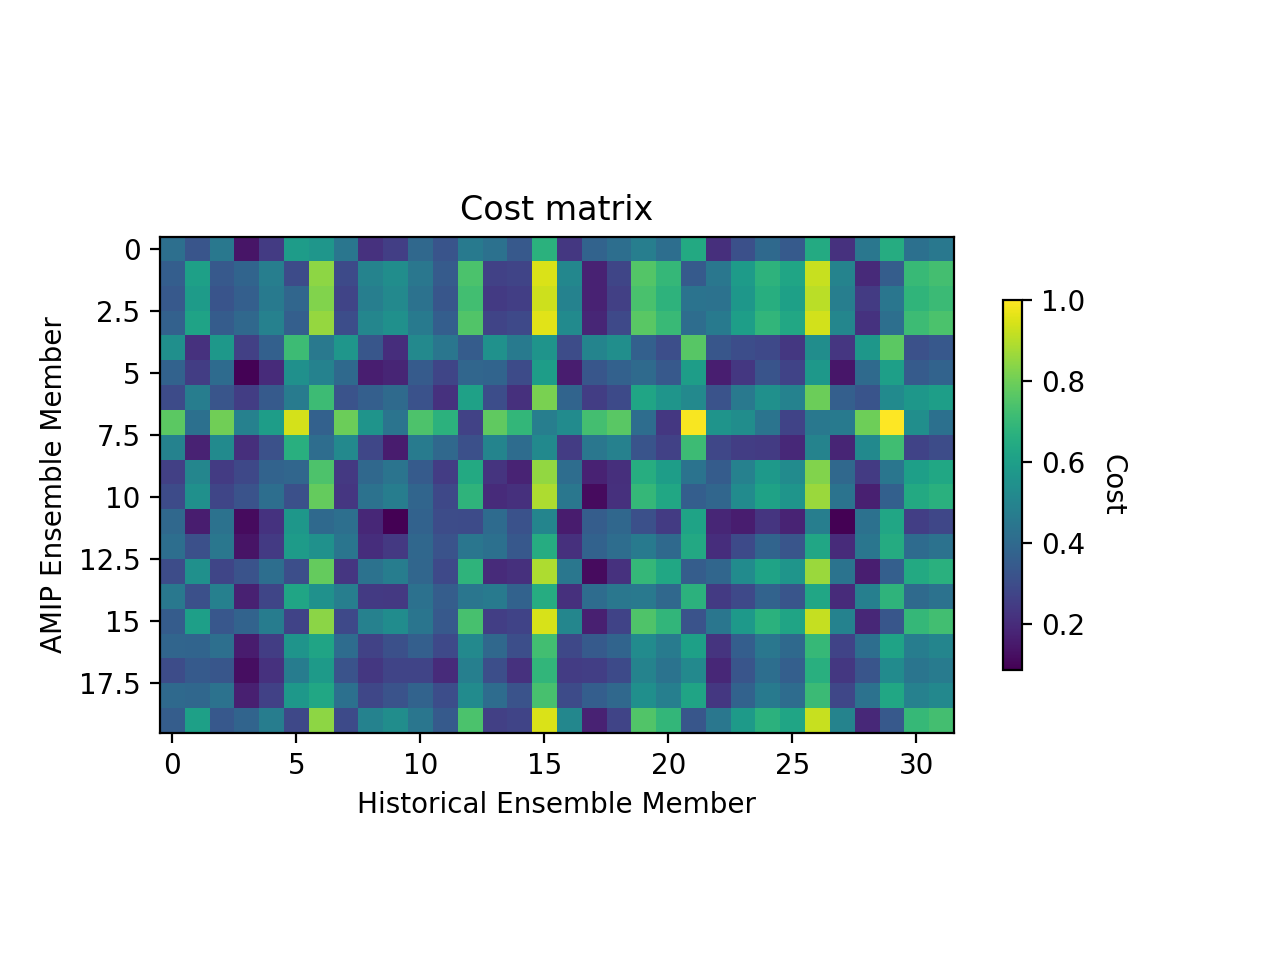

In [13]:
%%time

#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Generate the cost matrix with p=1
cost_matrix = ot.dist(amip_outputs, historical_outputs, metric='minkowski', p=1)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix_p=1', bbox_inches='tight', dpi=300)

#Now compute Wasserstein distance, which takes the weights and the cost matrix
#NOTE: WE MUST TAKE THE pTH ROOT IN ORDER TO GET THE REAL WASSERSTEIN DISTANCE
wasserstein1_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)**(1/1)
print('The GISS model achieved a Wasserstein-1 score of:', np.round(wasserstein1_score,3))

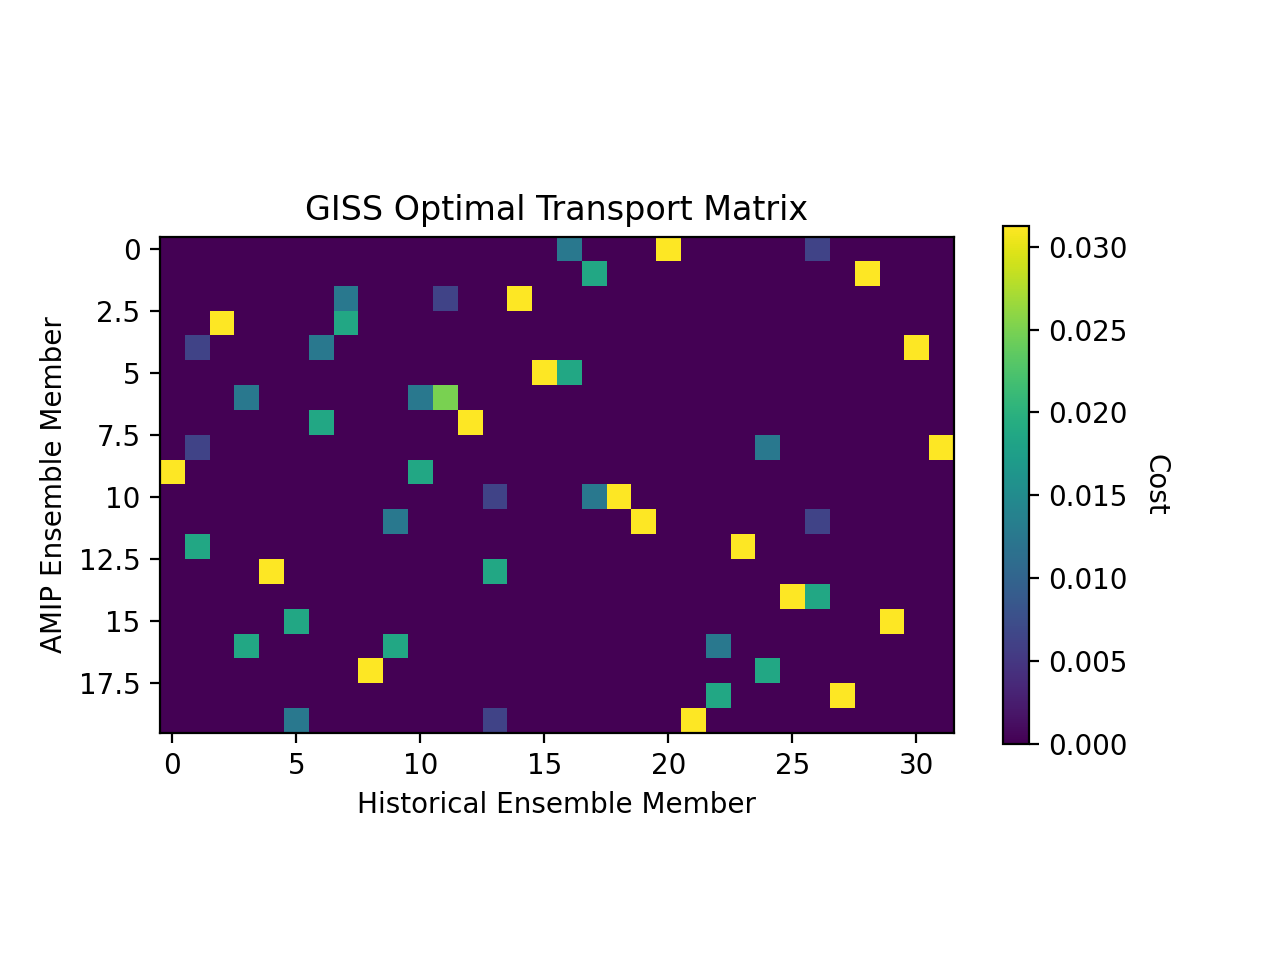

In [44]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

optimal_transport_p1 = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('GISS Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix_p=1', bbox_inches='tight', dpi=300)

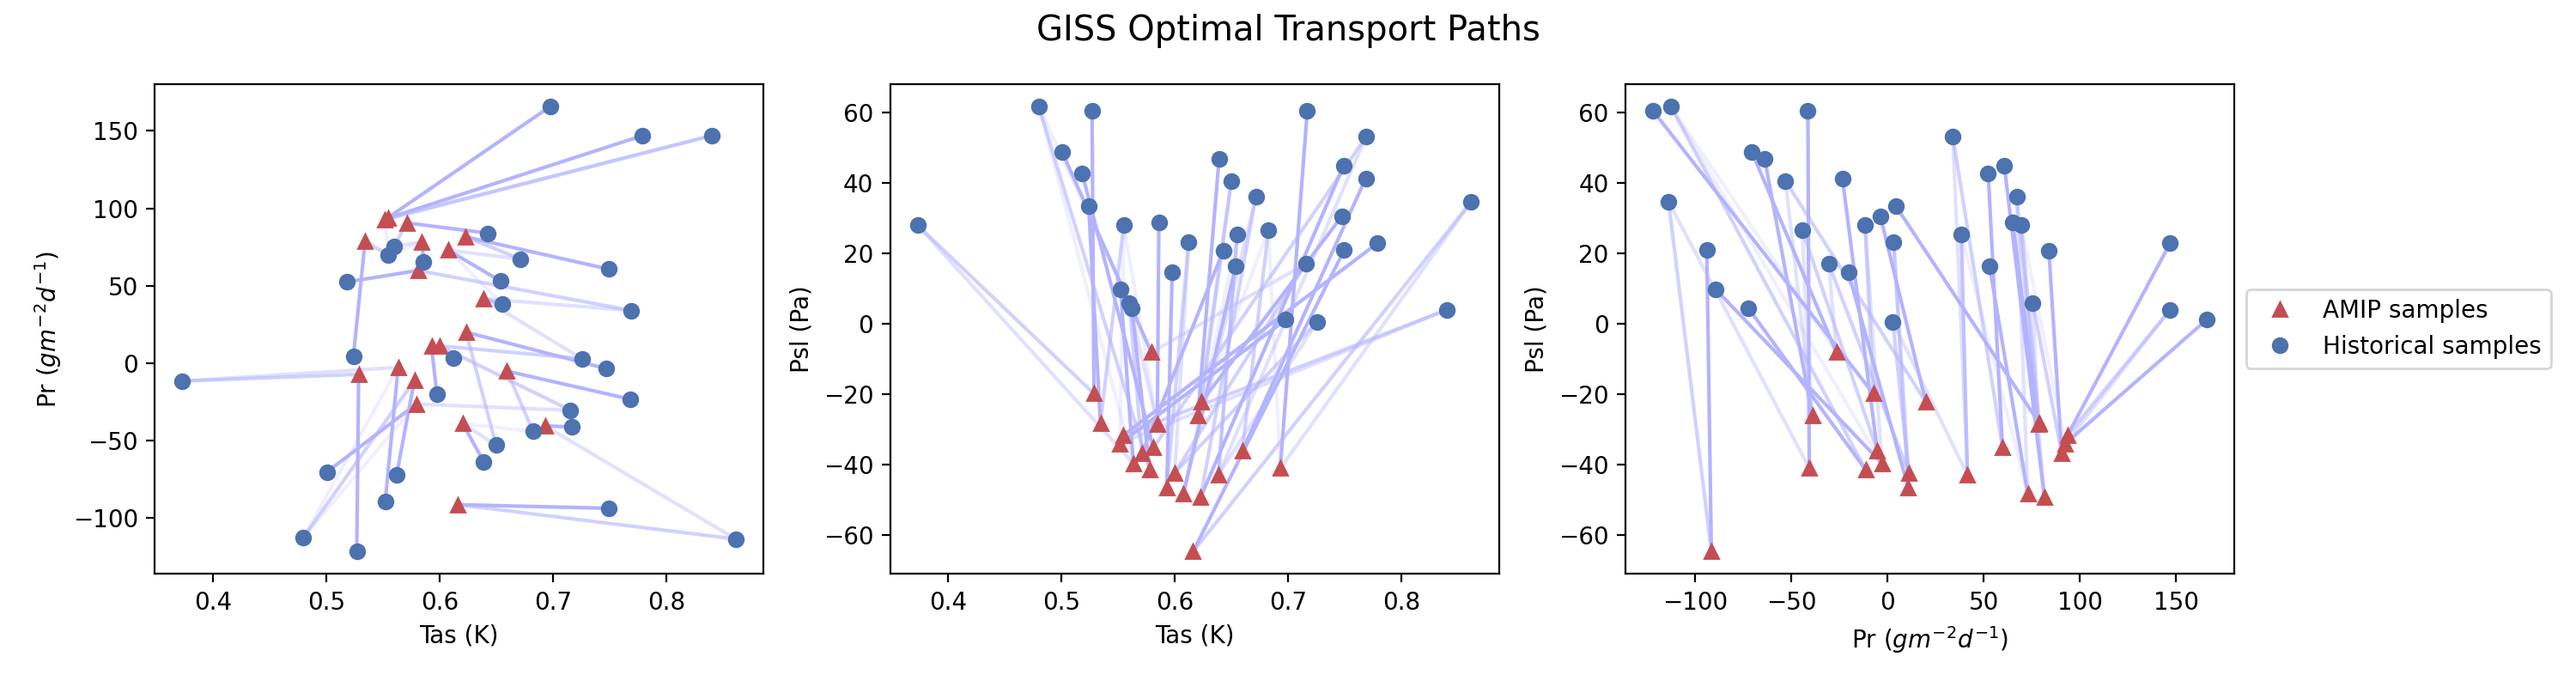

In [32]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("GISS Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('images/TasPrPsl_optimal_transport_paths_p=1', bbox_inches='tight', dpi=300)

### p=2

The GISS model achieved a Wasserstein-2 score of: 0.534
Wall time: 371 ms


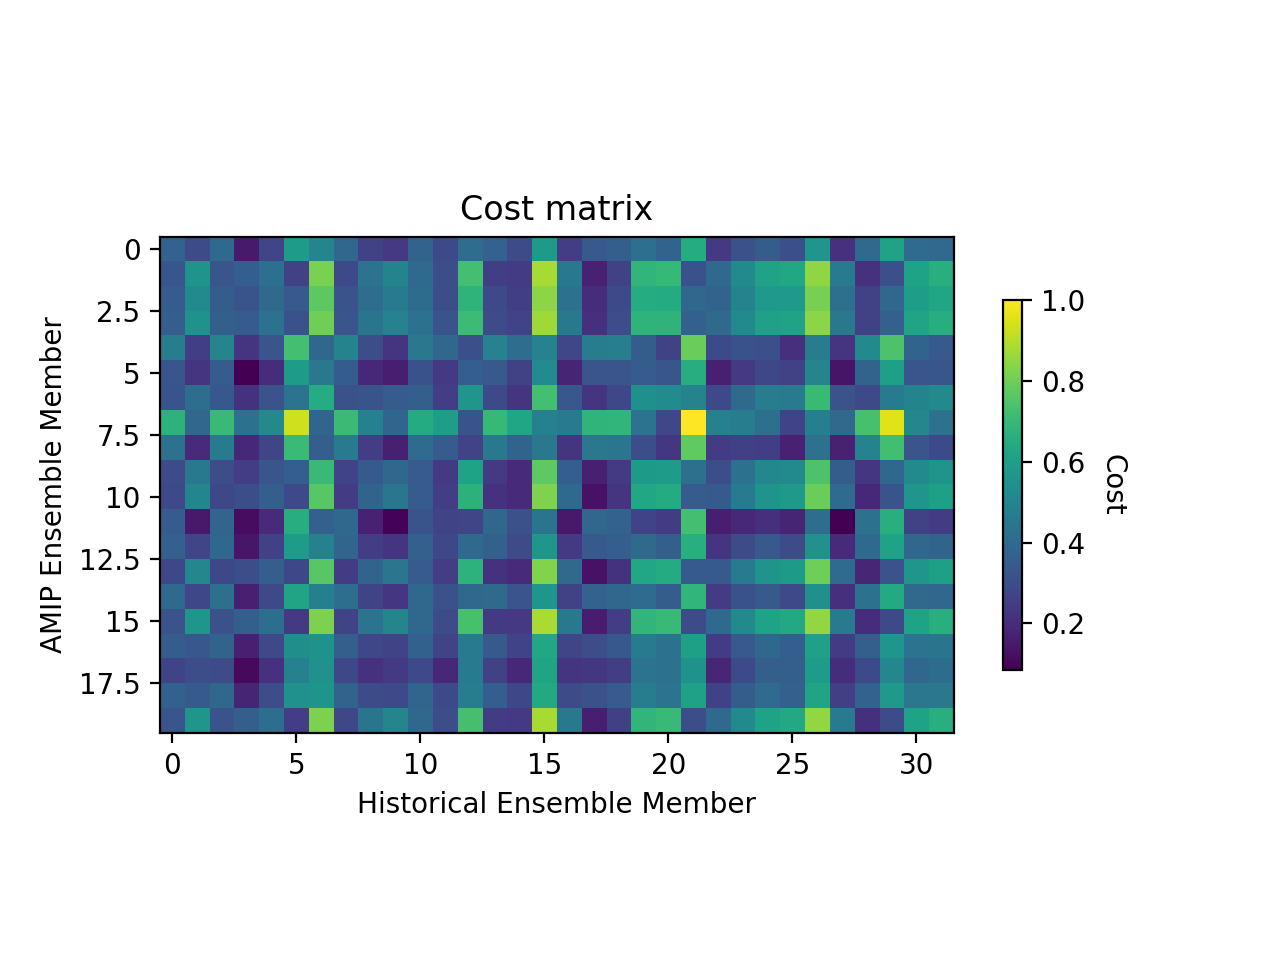

In [14]:
%%time

#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Generate the cost matrix with p=2
cost_matrix = ot.dist(amip_outputs, historical_outputs, metric='minkowski', p=2)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix_p=2', bbox_inches='tight', dpi=300)

#Now compute Wasserstein distance, which takes the weights and the cost matrix
#NOTE: WE MUST TAKE THE pTH ROOT IN ORDER TO GET THE REAL WASSERSTEIN DISTANCE
wasserstein2_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)**(1/2)
print('The GISS model achieved a Wasserstein-2 score of:', np.round(wasserstein2_score,3))

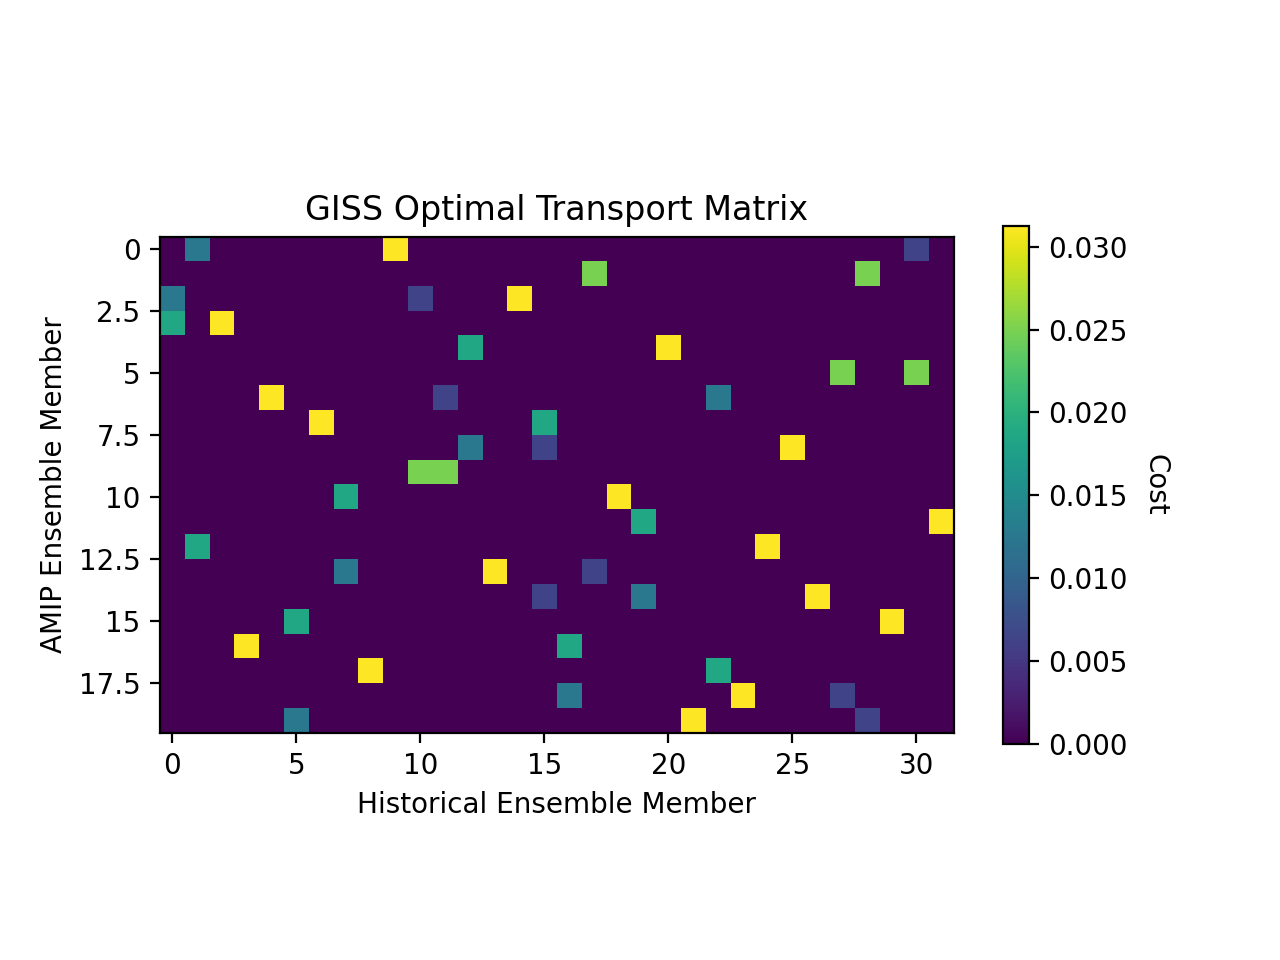

In [40]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

optimal_transport_p2 = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('GISS Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix_p=2', bbox_inches='tight', dpi=300)

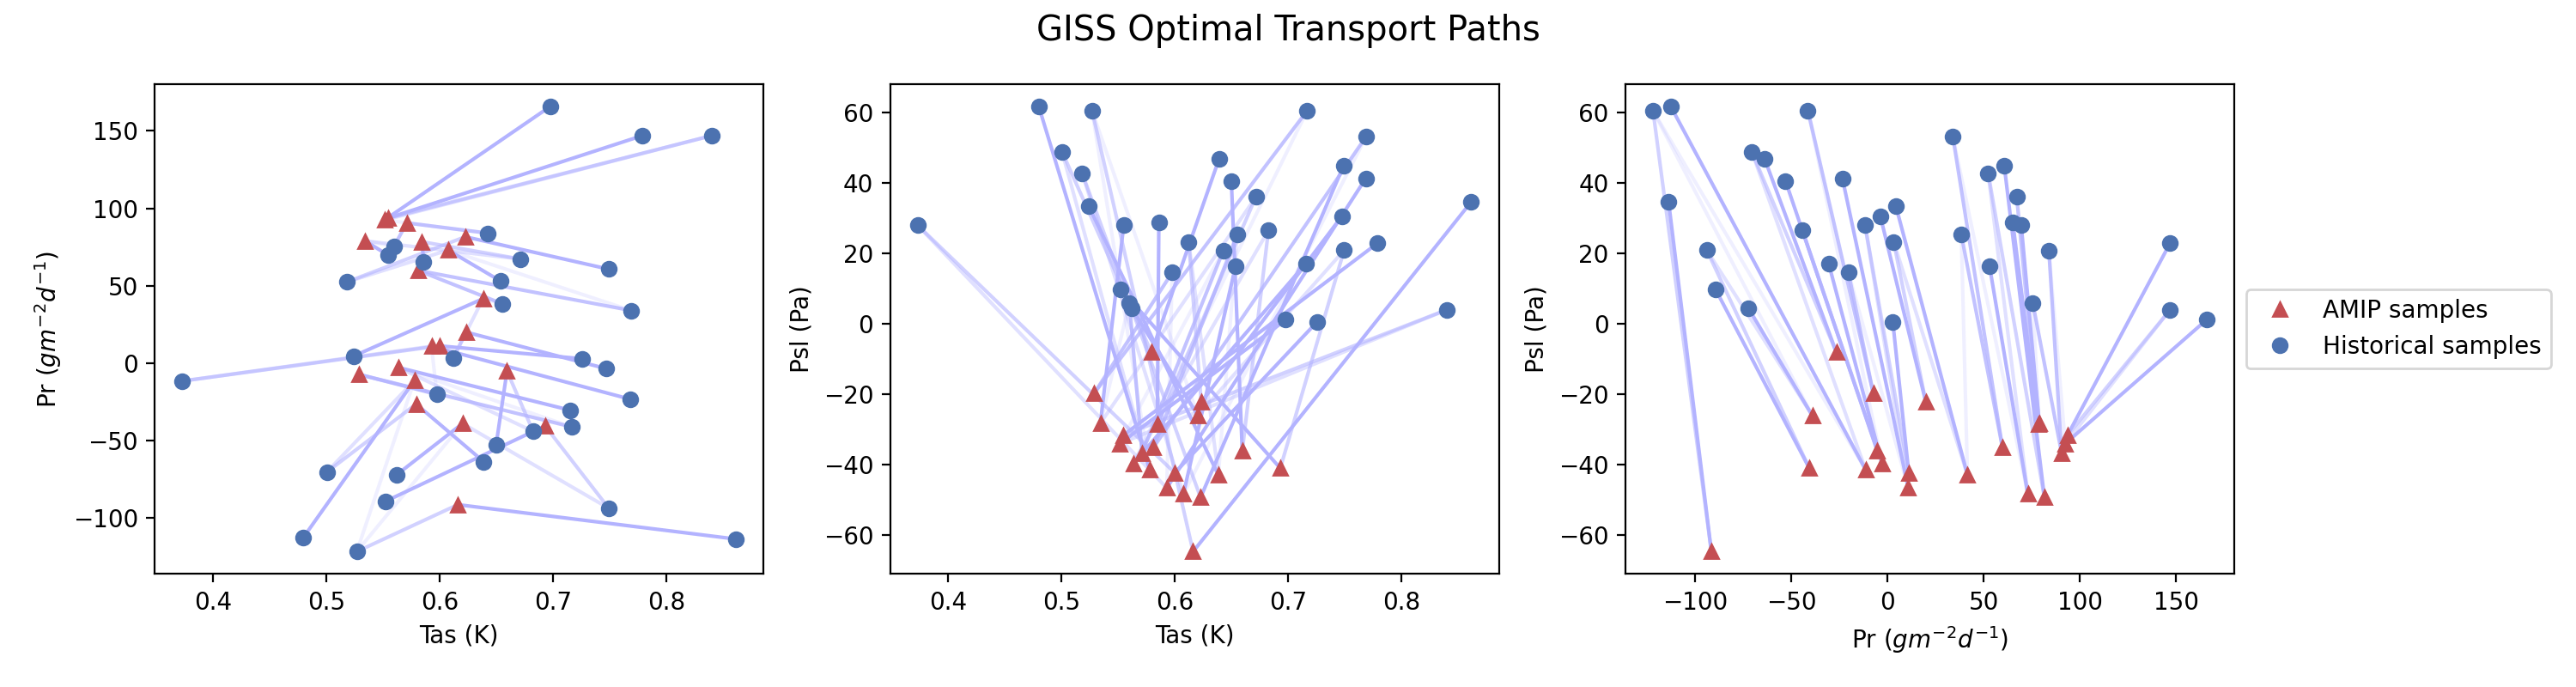

In [22]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("GISS Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('images/TasPrPsl_optimal_transport_paths_p=2', bbox_inches='tight', dpi=300)

### p=3

The GISS model achieved a Wasserstein-3 score of: 0.651
Wall time: 368 ms


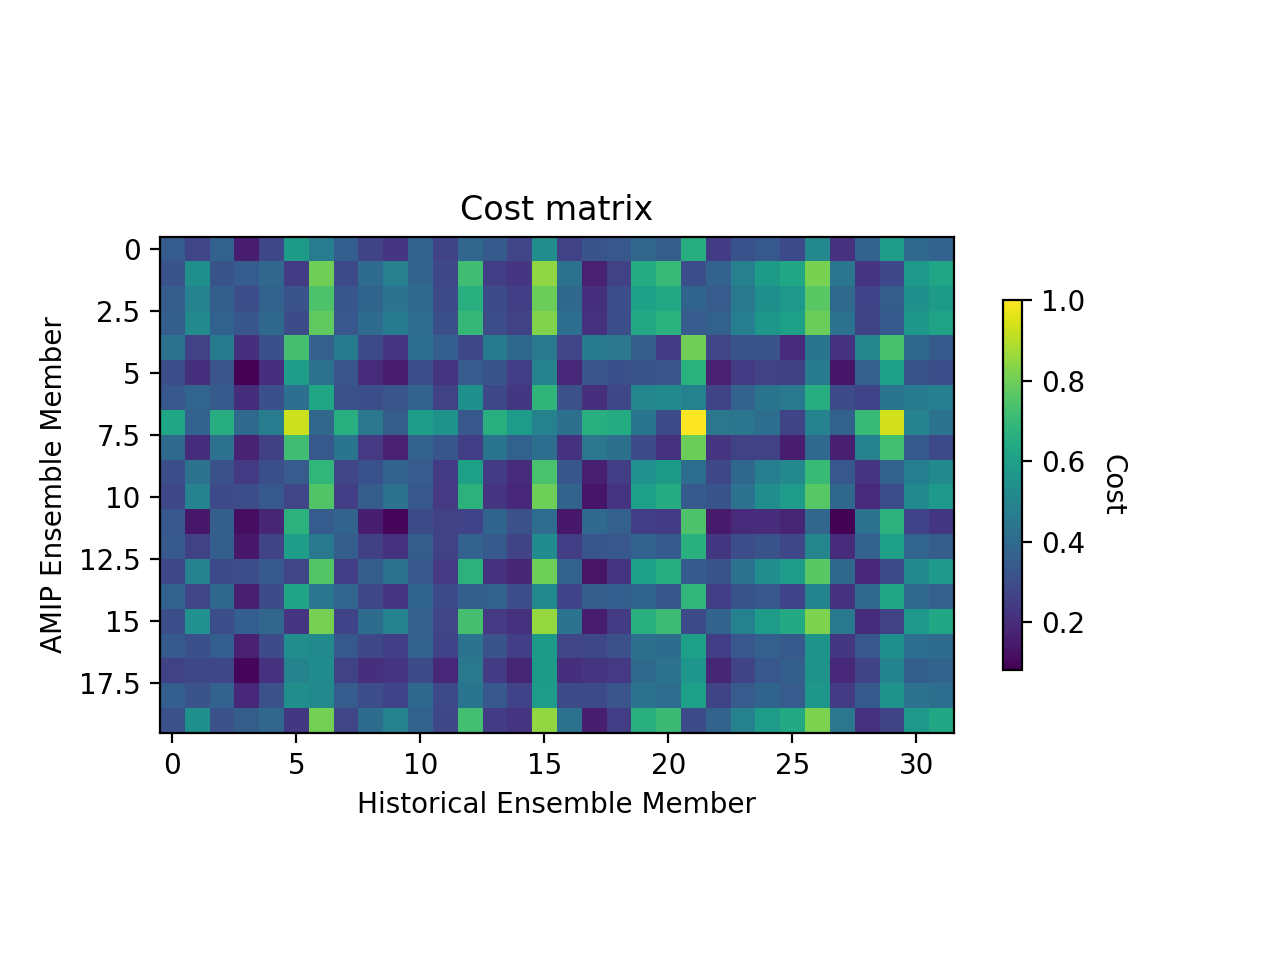

In [15]:
%%time

#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Generate the cost matrix with p=3
cost_matrix = ot.dist(amip_outputs, historical_outputs, metric='minkowski', p=3)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.5)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix_p=3', bbox_inches='tight', dpi=300)

#Now compute Wasserstein distance, which takes the weights and the cost matrix
#NOTE: WE MUST TAKE THE pTH ROOT IN ORDER TO GET THE REAL WASSERSTEIN DISTANCE
wasserstein3_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)**(1/3)
print('The GISS model achieved a Wasserstein-3 score of:', np.round(wasserstein3_score,3))

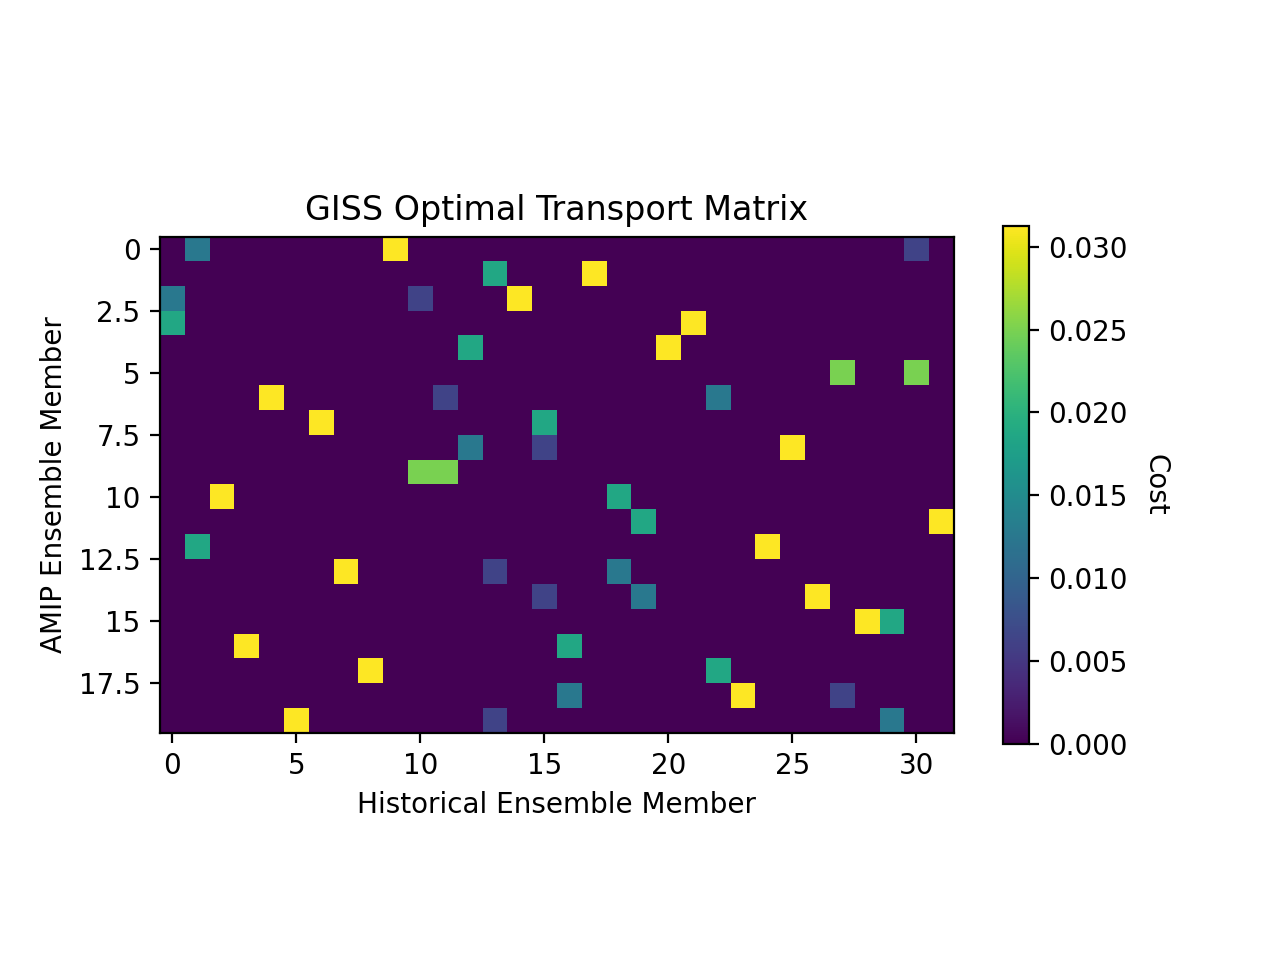

In [42]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

optimal_transport_p3 = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('GISS Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix_p=3', bbox_inches='tight', dpi=300)

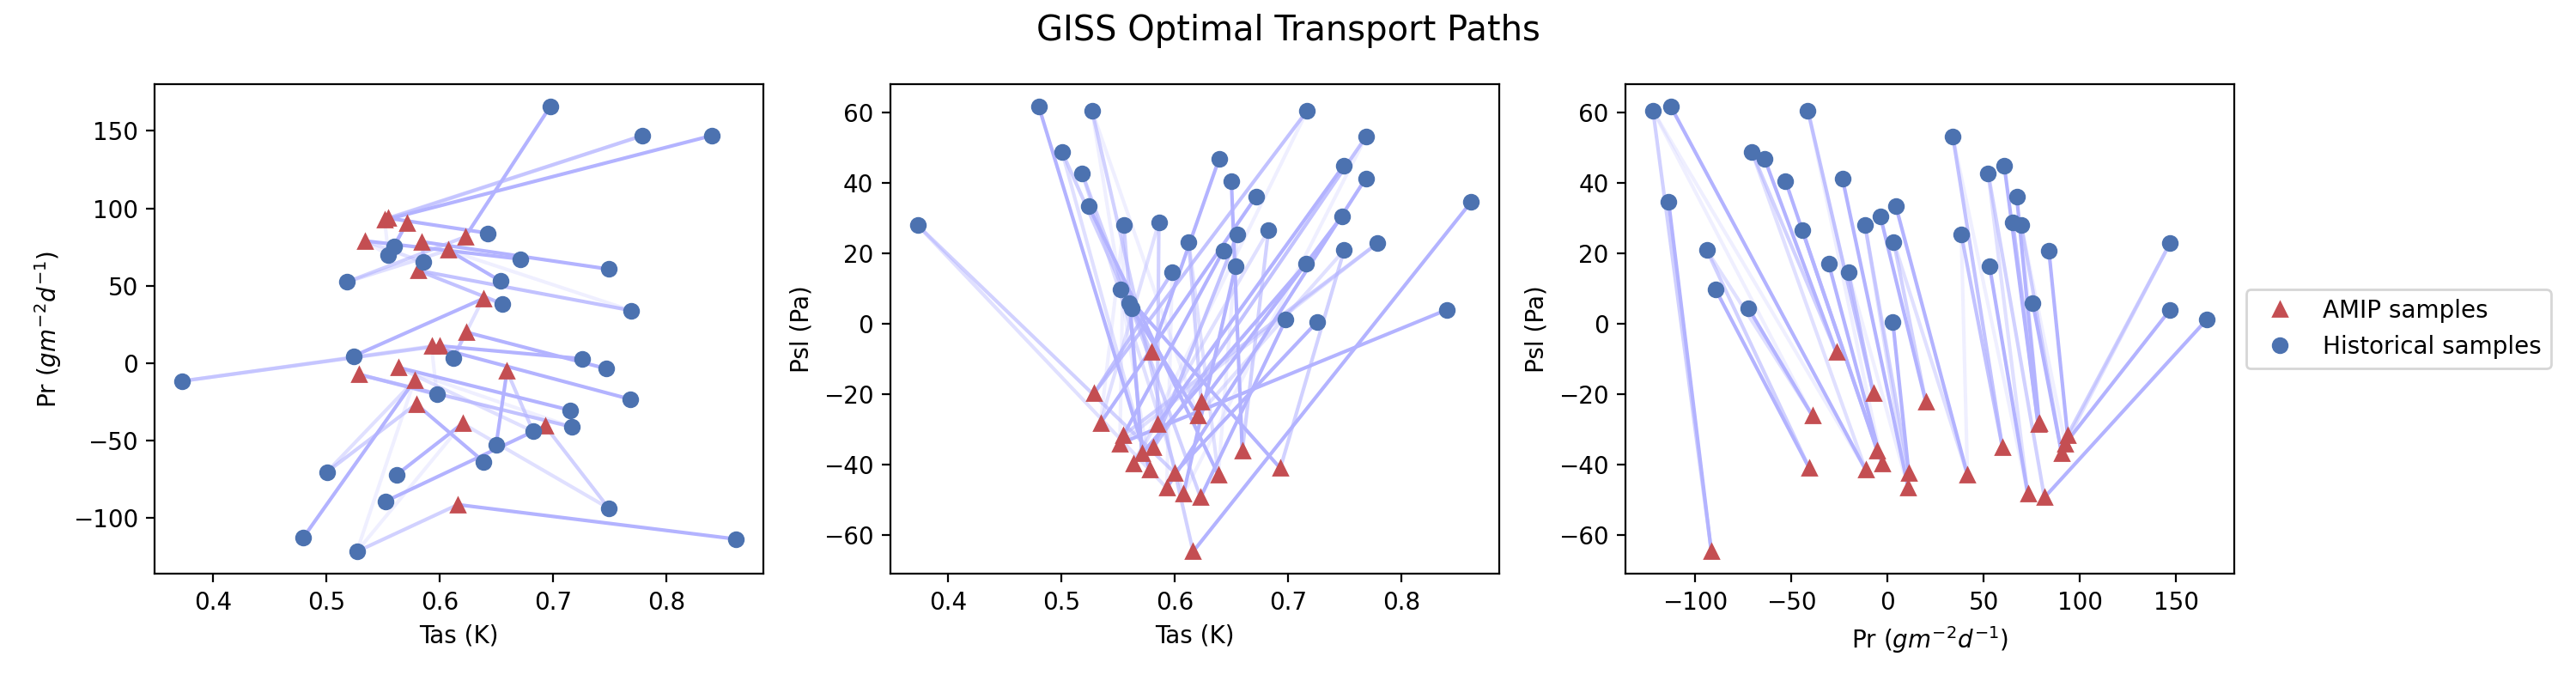

In [25]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("GISS Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('images/TasPrPsl_optimal_transport_paths_p=3', bbox_inches='tight', dpi=300)

### Summarise

In [36]:
wasserstein_scores = [wasserstein1_score, wasserstein2_score, wasserstein3_score]
np.round(wasserstein_scores,3)

array([0.303, 0.534, 0.651])

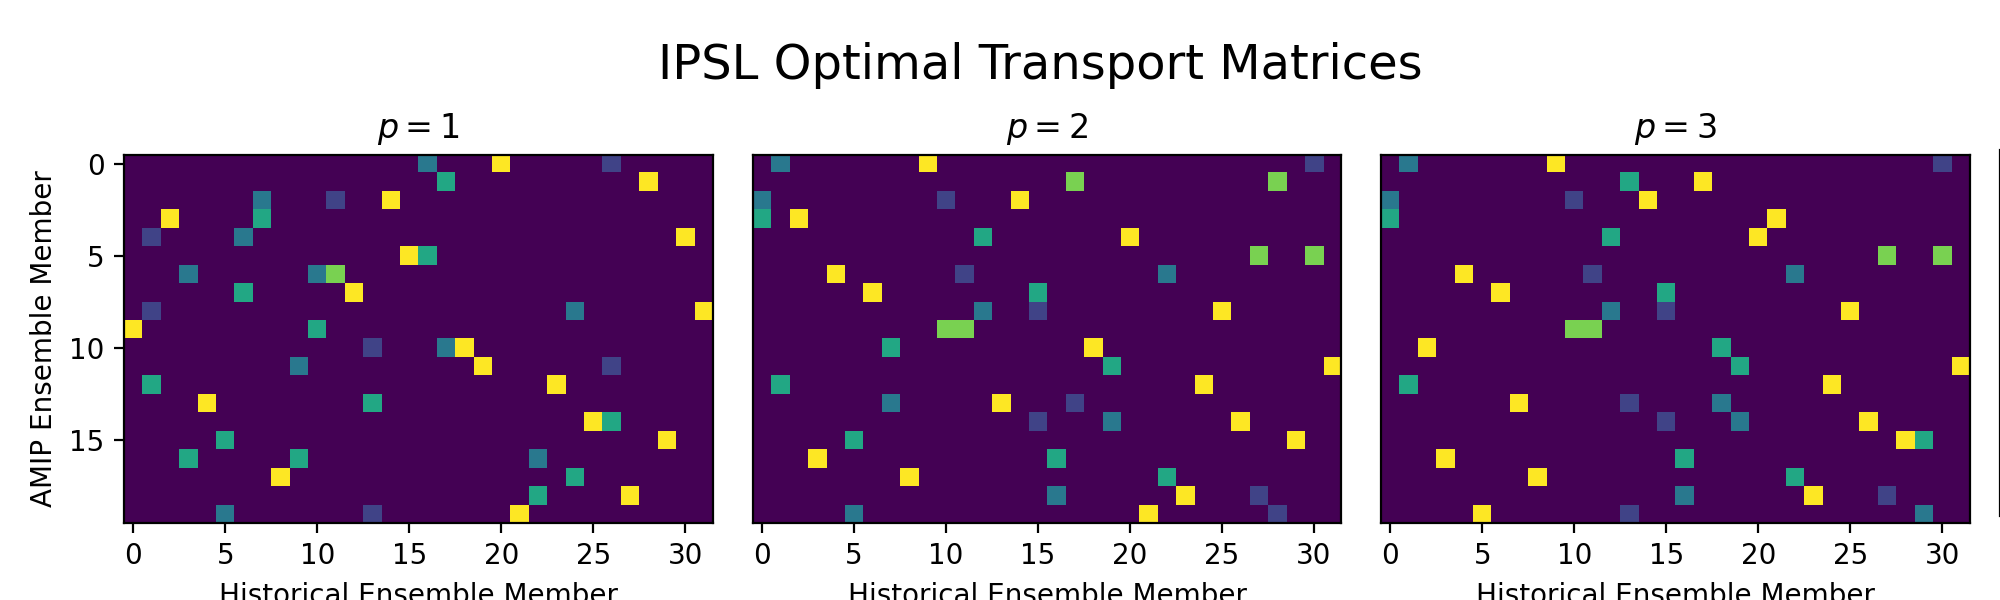

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), subplot_kw={'aspect': 1})

im = ax[0].imshow(optimal_transport_p1, interpolation='nearest')
ax[0].set_xlabel('Historical Ensemble Member')
ax[0].set_ylabel('AMIP Ensemble Member')
ax[0].set_title('$p=1$')

im = ax[1].imshow(optimal_transport_p2, interpolation='nearest')
ax[1].set_xlabel('Historical Ensemble Member')
ax[1].set_yticks([])
ax[1].set_title('$p=2$')

im = ax[2].imshow(optimal_transport_p3, interpolation='nearest')
ax[2].set_xlabel('Historical Ensemble Member')
ax[2].set_yticks([])
ax[2].set_title('$p=3$')

#Add a colorbar
cbar_ax = fig.add_axes([1, 0.14, 0.04, 0.61])
cbar = fig.colorbar(im, cbar_ax)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.suptitle('IPSL Optimal Transport Matrices', fontsize='xx-large', x=0.52, y=0.93)
plt.tight_layout()

plt.savefig('images/TasPrPsl_optimal_transport_matrices.eps', bbox_inches='tight', dpi=300, format='eps')

### Old

In [ ]:
#Generate the cost matrix
cost_matrix = ot.dist(amip_outputs, historical_outputs)

#Divide by the maximum value
cost_matrix /= cost_matrix.max()

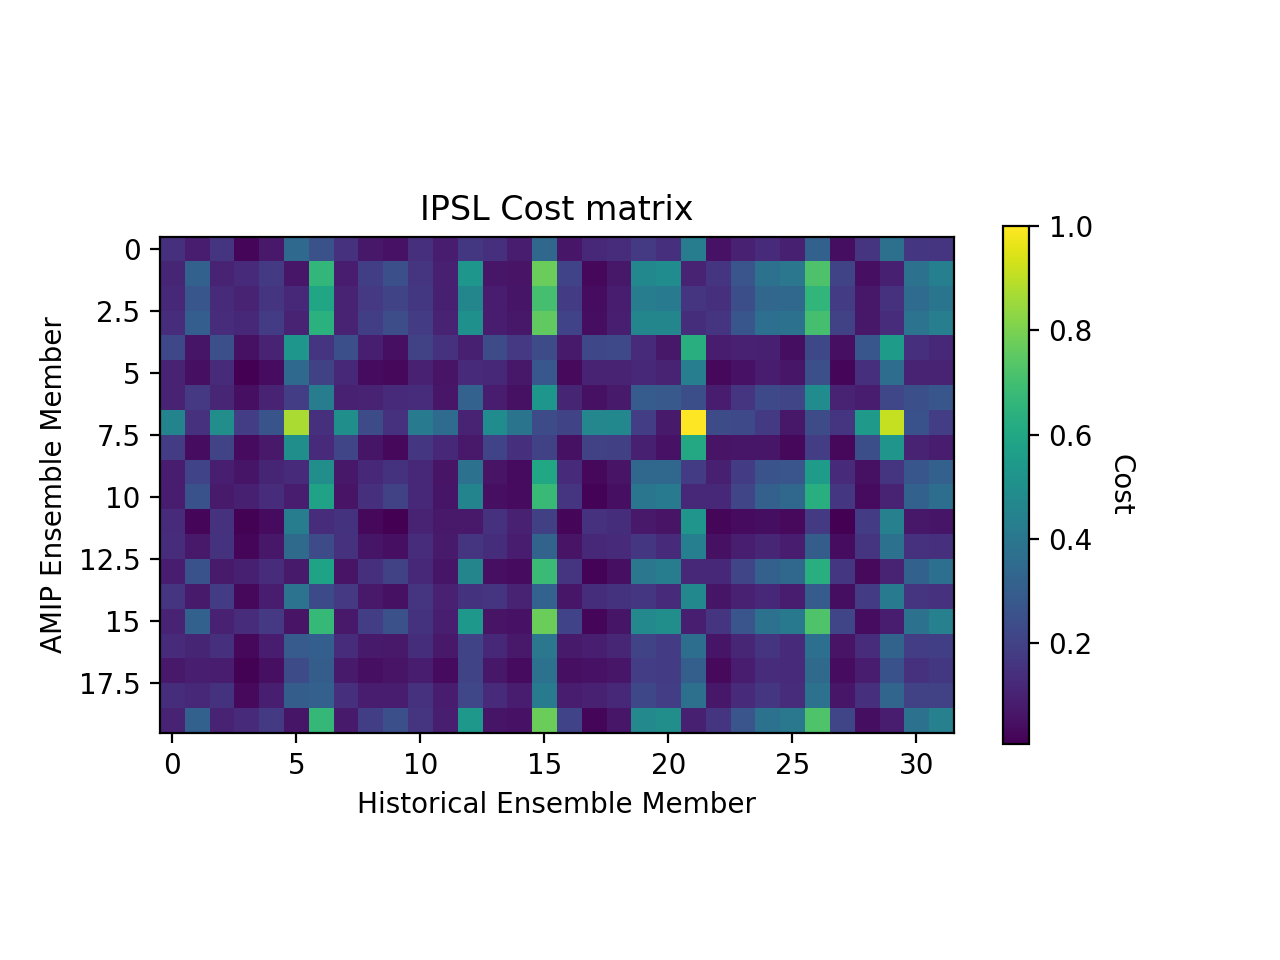

In [158]:
#Cheap fix to stop kernel dying:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Plot the cost matrix:
plt.imshow(cost_matrix, interpolation ='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('IPSL Cost matrix')

plt.savefig('images/TasPrPsl_cost_matrix', bbox_inches='tight', dpi=300)

In [1]:
#Now compute Wasserstein distance, which takes the weights and the cost matrix
wasserstein_score = ot.emd2(amip_weights, historical_weights,
                            cost_matrix)
print('The IPSL model achieved a Wasserstein score of:', np.round(wasserstein_score,3))

NameError: name 'ot' is not defined

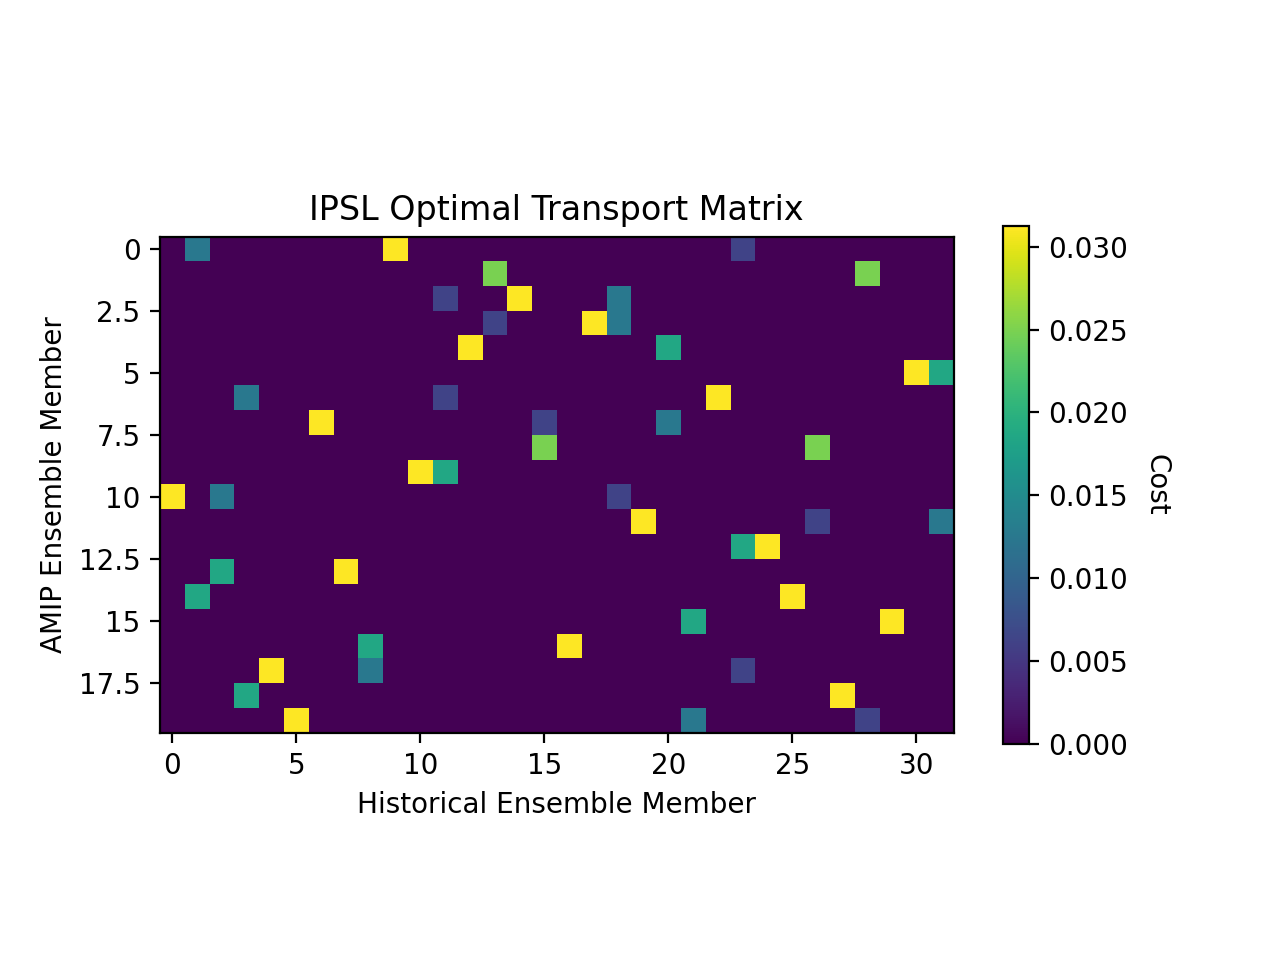

In [157]:
#Compute the optimal transport matrix:
optimal_transport = ot.emd(amip_weights, historical_weights,
                            cost_matrix)

plt.imshow(optimal_transport, interpolation='nearest')

#Add a colorbar below
cbar = plt.colorbar(shrink=0.7)
cbar.set_label('Cost', rotation=270,labelpad=15)

plt.xlabel('Historical Ensemble Member')
plt.ylabel('AMIP Ensemble Member')
plt.title('IPSL Optimal Transport Matrix')

plt.savefig('images/TasPrPsl_optimal_transport_matrix', bbox_inches='tight', dpi=300)

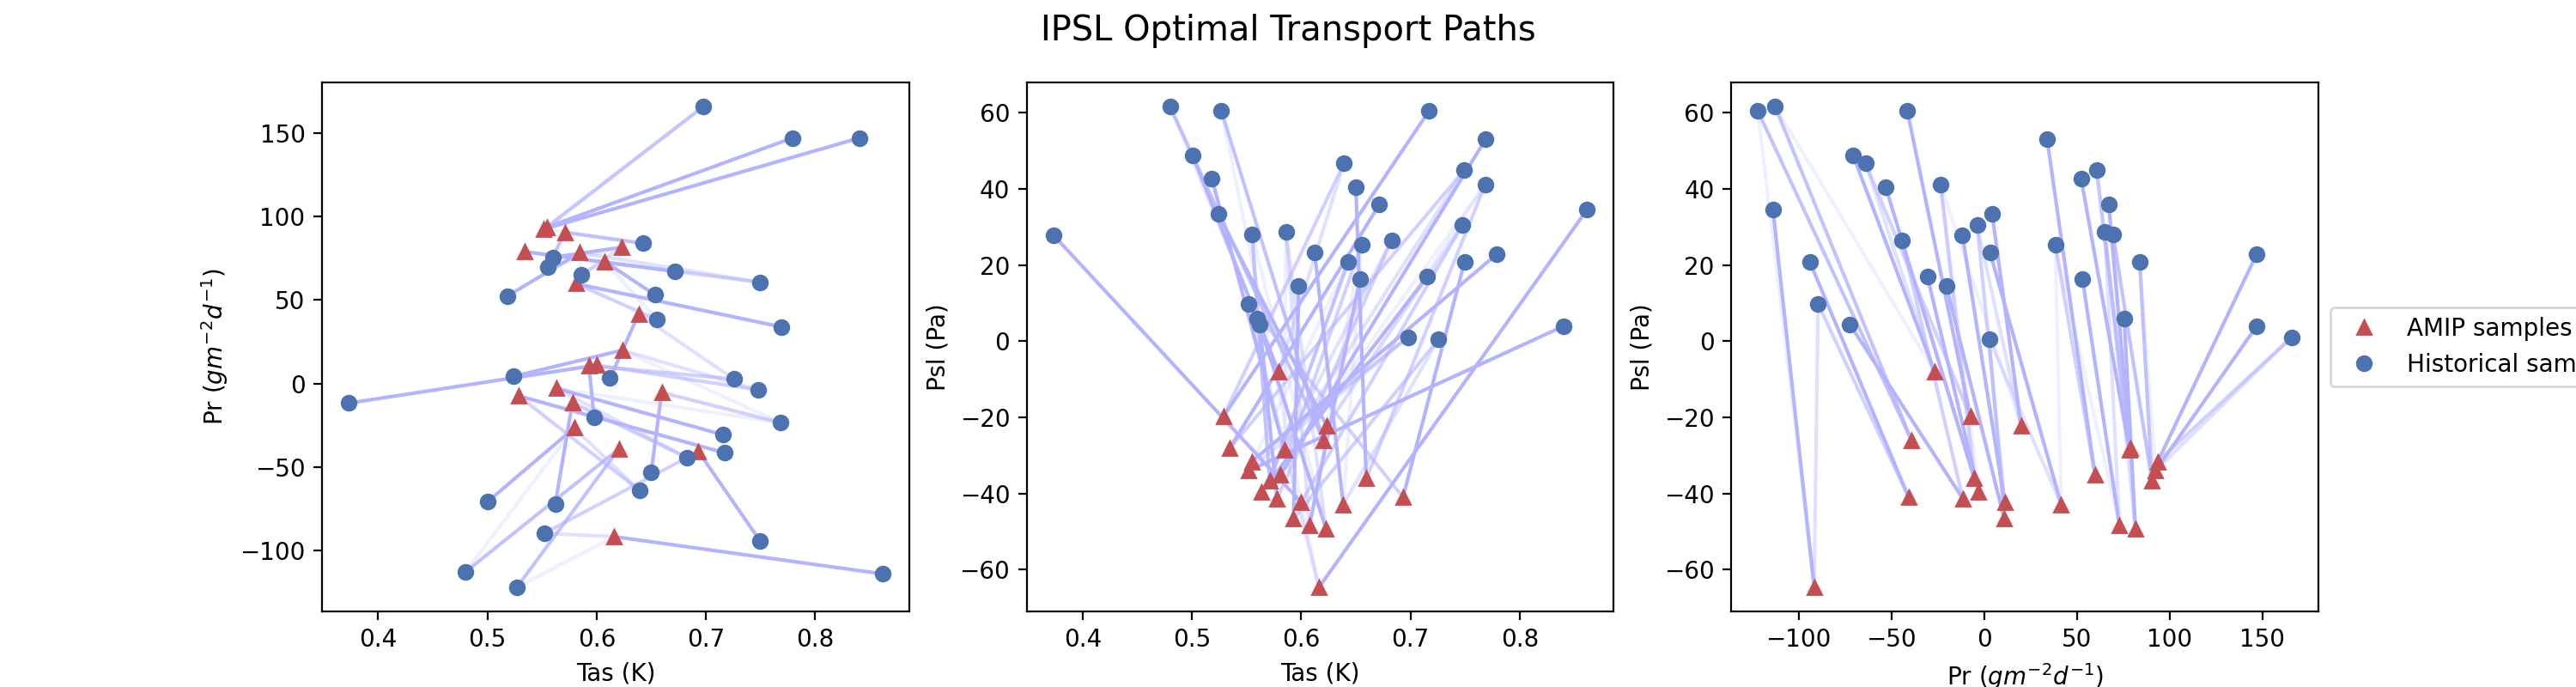

In [185]:
plt.figure(1, figsize=(15, 4))

plt.suptitle("IPSL Optimal Transport Paths", fontsize="x-large")

#Tas vs Pr
plt.subplot(1, 3, 1)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,1]], historical_outputs[:,[0,1]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 1], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 1], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Pr ($g m^{-2} d^{-1}$)')


#Tas vs Psl
plt.subplot(1, 3, 2)

ot.plot.plot2D_samples_mat(amip_outputs[:,[0,2]], historical_outputs[:,[0,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 0], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 0], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Tas (K)')
plt.ylabel('Psl (Pa)')


#Pr vs Psl
plt.subplot(1, 3, 3)

ot.plot.plot2D_samples_mat(amip_outputs[:,[1,2]], historical_outputs[:,[1,2]], optimal_transport, c=[.7, .7, 1])
plt.plot(amip_outputs[:, 1], amip_outputs[:, 2], 'r^', label='AMIP samples')
plt.plot(historical_outputs[:, 1], historical_outputs[:, 2], 'ob', label='Historical samples')

plt.xlabel('Pr ($g m^{-2} d^{-1}$)')
plt.ylabel('Psl (Pa)')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('images/TasPrPsl_optimal_transport_paths', bbox_inches='tight', dpi=300)

## Energy Distance

We use the Dcor package, which estimates the energy distance using Hoeffding's unbiased U statistics (see Dcor documentation for more info).
<br> However, the result returned is the <b>squared</b> distance, which is not a metric. So, we take the square root.

In [37]:
energy_score = np.sqrt(dcor.energy_distance(amip_outputs,historical_outputs))

In [38]:
print('The IPSL model achieved an energy score of:', np.round(energy_score,3))

The IPSL model achieved an energy score of: 7.944


My implementation, using the empirical estimators of expectation found by summing pairwise differences:

In [9]:
def calculate_energy_statistics(x, y):

    n = len(x)
    m = len(y)

    A = 0
    B = 0
    C = 0

    for i in range(n):
        for j in range(m):
            A += np.linalg.norm(x[i] - y[j])

    A = A / (n * m)

    for i in range(n):
        for j in range(n):
            B += np.linalg.norm(x[i] - x[j])

    B = B / (n * n)

    for i in range(m):
        for j in range(m):
            C += np.linalg.norm(y[i] - y[j])

    C = C / (m * m)

    energy_distance = np.sqrt(2 * A - B - C)

    test_statistic = (2 * A - B - C) / (2 * A)

    return {
        'Energy distance': np.round(energy_distance, 3),
        'Test statistic': np.round(test_statistic, 4)
    }

In [10]:
calculate_energy_statistics(amip_outputs, historical_outputs)

{'Energy distance': 7.944, 'Test statistic': 0.2898}